In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#pip install pandas_ta

In [3]:
import pandas_ta as ta

In [4]:
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [5]:
bist_daily = pd.read_csv("datasets/bist_100_daily.csv")
# Extract the number of rows and columns by using the shape of the data.
numRows,numColumns = bist_daily.shape
# Extract the time interval.
last_date, first_date = bist_daily.iloc[0].Date, bist_daily.iloc[-1].Date
# Check the availability of the data.
na_cols = bist_daily.columns[bist_daily.isna().any()].tolist()

# Print the information.
print(f"There are {numRows} rows and {numColumns} columns in the initial dataset.")
print(f"The data represents the time frame between the dates '{last_date}' and '{first_date}'.")
if not na_cols:
    print("There are no NA rows.")
else:
    print(f"Columns in the dataset which include NA rows: {na_cols}.")
# Convert columns to numeric values
column_names = ["Price", "Open", "High", "Low"]
for column in column_names:
    bist_daily[column] = bist_daily[column].str.replace(',', '')
    bist_daily[column] = pd.to_numeric(bist_daily[column])
# CONVERT TO DATETIME FORMAT AND SORT DATA BY DATE
bist_daily.Date = pd.to_datetime(bist_daily.Date)
bist_daily.sort_values(by="Date", ignore_index=True,inplace=True)
bist_daily.set_index(pd.DatetimeIndex(bist_daily["Date"]), inplace=True)
bist_daily.rename(columns={"Price": "close"},inplace=True)
# Calculate Returns and append to the df DataFrame
# CUMLOGRET_1 and CUMPCTRET_1 are added (NaN values exists)
bist_daily.ta.log_return(cumulative=True, append=True)
bist_daily.ta.percent_return(cumulative=True, append=True)
# Returns a list of indicators and utility functions (to check in future)
ind_list = bist_daily.ta.indicators(as_list=True)
# RSI_14, MACD_12_26_9, MACDh_12_26_9 and MACDs_12_26_9 are added (NaN values exists)
bist_daily.ta.rsi(append=True)
bist_daily.ta.macd(append=True)
# SMA values are added (use ta in the future)
sma_values = [5, 10, 15] 
for i in sma_values:
    bist_daily['SMA'+str(i)] = bist_daily['close'].rolling(window=i).mean()
# Remove all NaN value rows
bist_daily.dropna(inplace=True)
bist_daily

There are 5000 rows and 7 columns in the initial dataset.
The data represents the time frame between the dates 'Dec 11, 2019' and 'Jan 04, 2000'.
There are no NA rows.


,date,close,open,high,low,Vol.,Change %,CUMLOGRET_1,CUMPCTRET_1,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA5,SMA10,SMA15
date,,,,,,,,,,,,,,,,
2000-02-21,2000-02-21,145.69,153.64,153.64,142.79,25.75M,-5.17%,-0.183990,-0.160515,34.352566,-7.230371,-0.392050,-6.838321,153.936,155.116,157.896000
2000-02-22,2000-02-22,139.94,145.69,147.02,137.58,29.58M,-3.95%,-0.224258,-0.199983,31.136786,-8.027940,-0.951695,-7.076245,150.206,153.060,156.330667
2000-02-23,2000-02-23,134.47,139.94,141.26,131.71,26.95M,-3.91%,-0.264130,-0.239071,28.411996,-8.997682,-1.537150,-7.460532,145.432,151.074,154.602000
2000-02-24,2000-02-24,146.52,134.47,146.52,134.14,43.02M,8.96%,-0.178310,-0.149460,40.719161,-8.693661,-0.986503,-7.707158,144.052,149.896,153.638667
2000-02-25,2000-02-25,156.18,146.52,156.32,146.52,56.16M,6.59%,-0.114462,-0.083530,48.380526,-7.585796,0.097090,-7.682886,144.560,149.916,152.803333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-05,2019-12-05,1086.59,1082.60,1090.32,1081.51,2.24B,0.89%,1.825328,2.894902,66.153619,16.788401,0.360019,16.428382,1076.116,1068.981,1068.217333
2019-12-06,2019-12-06,1088.69,1090.09,1093.15,1083.52,2.16B,0.19%,1.827259,2.896834,66.774984,17.187282,0.607120,16.580162,1080.046,1071.262,1070.543333
2019-12-09,2019-12-09,1087.86,1088.96,1091.25,1081.39,2.32B,-0.08%,1.826496,2.896072,66.257244,17.237719,0.526046,16.711673,1081.610,1074.666,1071.836667


In [6]:
# edit Vol. column

from operator import itemgetter

vols = bist_daily['Vol.'].to_list()
#[vol[-1] for vol in vols]
#list(filter(lambda vol: "-" in vol,enumerate(vols)))

indexToRemove = bist_daily.iloc[list(map(itemgetter(0),filter(lambda vol: "-" in vol,enumerate(vols))))].index
bist_daily.drop(indexToRemove,inplace=True)
bist_daily['Vol.'] = bist_daily['Vol.'].apply(
    lambda x: float(x[:-1])*(10**6) if x[-1]=="M" else (float(x[:-1])*(10**9) if x[-1]=="B" else "ERROR")).astype("int")
bist_daily

,date,close,open,high,low,Vol.,Change %,CUMLOGRET_1,CUMPCTRET_1,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA5,SMA10,SMA15
date,,,,,,,,,,,,,,,,
2000-02-21,2000-02-21,145.69,153.64,153.64,142.79,25750000,-5.17%,-0.183990,-0.160515,34.352566,-7.230371,-0.392050,-6.838321,153.936,155.116,157.896000
2000-02-22,2000-02-22,139.94,145.69,147.02,137.58,29580000,-3.95%,-0.224258,-0.199983,31.136786,-8.027940,-0.951695,-7.076245,150.206,153.060,156.330667
2000-02-23,2000-02-23,134.47,139.94,141.26,131.71,26950000,-3.91%,-0.264130,-0.239071,28.411996,-8.997682,-1.537150,-7.460532,145.432,151.074,154.602000
2000-02-24,2000-02-24,146.52,134.47,146.52,134.14,43020000,8.96%,-0.178310,-0.149460,40.719161,-8.693661,-0.986503,-7.707158,144.052,149.896,153.638667
2000-02-25,2000-02-25,156.18,146.52,156.32,146.52,56160000,6.59%,-0.114462,-0.083530,48.380526,-7.585796,0.097090,-7.682886,144.560,149.916,152.803333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-05,2019-12-05,1086.59,1082.60,1090.32,1081.51,-2147483648,0.89%,1.825328,2.894902,66.153619,16.788401,0.360019,16.428382,1076.116,1068.981,1068.217333
2019-12-06,2019-12-06,1088.69,1090.09,1093.15,1083.52,-2147483648,0.19%,1.827259,2.896834,66.774984,17.187282,0.607120,16.580162,1080.046,1071.262,1070.543333
2019-12-09,2019-12-09,1087.86,1088.96,1091.25,1081.39,-2147483648,-0.08%,1.826496,2.896072,66.257244,17.237719,0.526046,16.711673,1081.610,1074.666,1071.836667


In [7]:
# seeding an arbitrary number to get same results in multiple runs
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Seed:", manualSeed)

Seed: 999


In [8]:
# getting number of GPUs from cuda
ngpu = torch.cuda.device_count()
print("Count of available GPUs:", ngpu)

Count of available GPUs: 1


In [9]:
# printing the name of available GPUs
for i in range(ngpu):
    print("GPU {}: {}".format(i+1, torch.cuda.get_device_name(i)))

GPU 1: GeForce RTX 2060


In [10]:
# batch size for the training
batch_size = 64

# optimizer rates
optimizer_betas = (0.9, 0.999)
learning_rate = 1e-3

# number of epochs
num_epochs = 100000

# decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [11]:
class TimeseriesDataset(Dataset):
    def __init__(self, data_frame, sequence_length=2):
        self.data = torch.tensor(data_frame.values)
        self.sequence_length = sequence_length

    def __len__(self):
        return self.data.shape[0] - self.sequence_length + 1

    def __getitem__(self, index):
        return self.data[index: index + self.sequence_length].float()
    
    # Non-overlapping series
    # def __getitem__(self, index):
    #     return self.data[index * self.sequence_length: (index+1) * self.sequence_length]

In [12]:
# create pytorch dataset from the pandas DataFrame

# TODO: Convert change(%) and Volume columns to numeric values
columns_used_in_training = ["close", "open", "high", "low", "CUMLOGRET_1", "RSI_14", "MACD_12_26_9", "SMA5"]
# input dimension of the generator
data_dimension = len(columns_used_in_training)
# sequence length of input data
sequence_length = 14

train_data, rest_data = train_test_split(bist_daily[columns_used_in_training], test_size=0.2, shuffle=False)

scaler = MinMaxScaler()
scaler.fit(train_data)
train_data[train_data.columns] = scaler.transform(train_data)
rest_data[rest_data.columns] = scaler.transform(rest_data)

validation_data, test_data = train_test_split(rest_data, test_size=0.5, shuffle=False)

train_dataset = TimeseriesDataset(train_data, sequence_length)
test_dataset = TimeseriesDataset(test_data, sequence_length)
validation_dataset = TimeseriesDataset(validation_data, sequence_length)

# create the dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
real_data_sample = next(iter(train_dataloader))
print("Real data sample shape:", real_data_sample.shape)

Real data sample shape: torch.Size([64, 14, 8])


In [13]:
class Generator(nn.Module):
    def __init__(self, hidden_size):
        super(Generator, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=data_dimension, hidden_size=hidden_size, num_layers=2, dropout=0.2, batch_first=True)
        self.linear = nn.Linear(hidden_size, data_dimension)
        self.drop = nn.Dropout(0.2)

    def forward(self, input_sequences):
        input_sequences = self.drop(input_sequences)
        lstm_output, hidden_cell = self.lstm(input_sequences)
        res = self.linear(hidden_cell[0][-1])
        res = res.view(res.shape[0], 1, -1)
        return res

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(sequence_length*data_dimension, 72),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(72, 100),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(100, 10),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(10, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_sequences):
        input_sequences_flattened = input_sequences.view(input_sequences.shape[0], -1)
        res = self.model(input_sequences_flattened)
        return res

In [15]:
def model_rmse(model, dataloader, plot_graph=False, plot_title="Validation Predictions"):
    rmse = 0
    squared_error_list = []
    real_data_list = []
    predicted_data_list = []
    for i, sequence_batch in enumerate(dataloader):
        with torch.no_grad():
            real_sequence = sequence_batch
            # Assign first t values
            generator_input_sequence = sequence_batch[:,:-1].to(device)
            real_values = sequence_batch[:,-1:]
            #  Generate (t+1)th value from first t values
            predicted_values = generator(generator_input_sequence).cpu()
            squared_error_list.append((predicted_values - real_values) ** 2)
            real_data_list.append(real_values)
            predicted_data_list.append(predicted_values)
    squared_errors = torch.cat(squared_error_list, 0)
    real_data = torch.cat(real_data_list, 0)
    predicted_data = torch.cat(predicted_data_list, 0)
    # scaler.inverse_transform(X)
    if plot_graph:
        # TODO: get x values and plot prediction of multiple columns
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(plot_title)
        plt.plot(real_data[:,:,0].view(-1),label="Real")
        plt.plot(predicted_data[:,:,0].view(-1),label="Predicted")
        plt.ylim(bottom=0)
        plt.legend()
        plt.show()
    rmse = np.sqrt(squared_errors.mean())
    return rmse

In [16]:
# TODO: weight initialization of models

In [17]:
generator = Generator(hidden_size=data_dimension*4).to(device)
discriminator = Discriminator().to(device)
print("Generator and discriminator are initialized")

Generator and discriminator are initialized


In [18]:
criterion = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=optimizer_betas)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=optimizer_betas)

real_label = 1.
fake_label = 0.

In [19]:
if not os.path.exists('./models/'):
    os.makedirs('./models/')

Training is started


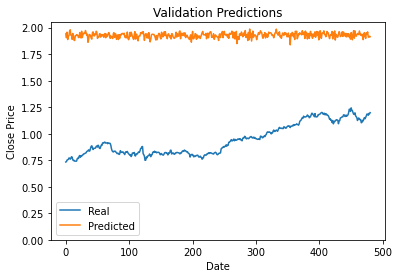


[1/100000]	Discriminator Loss: 1.3401	Generator Loss: 0.6779   	RMSE:1.1644
close | Real:0.1411 / Generated:1.9219
open | Real:0.1415 / Generated:1.6829
high | Real:0.1398 / Generated:1.4562
low | Real:0.1462 / Generated:1.9240
CUMLOGRET_1 | Real:0.3863 / Generated:2.2121
RSI_14 | Real:0.5512 / Generated:2.5150
MACD_12_26_9 | Real:0.6327 / Generated:2.0137
SMA5 | Real:0.1414 / Generated:1.7124


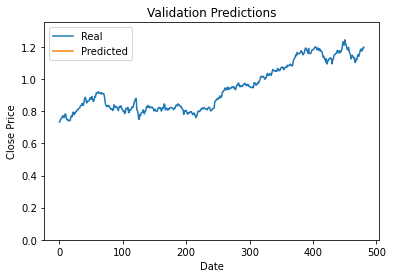


[5/100000]	Discriminator Loss: 1.4849	Generator Loss: 0.8026   	RMSE:1.3212
close | Real:0.6760 / Generated:-0.8933
open | Real:0.6760 / Generated:-0.4719
high | Real:0.6796 / Generated:0.3104
low | Real:0.6876 / Generated:-0.9844
CUMLOGRET_1 | Real:0.8615 / Generated:-0.1284
RSI_14 | Real:0.4435 / Generated:-0.3489
MACD_12_26_9 | Real:0.4765 / Generated:0.0421
SMA5 | Real:0.6752 / Generated:-0.1694


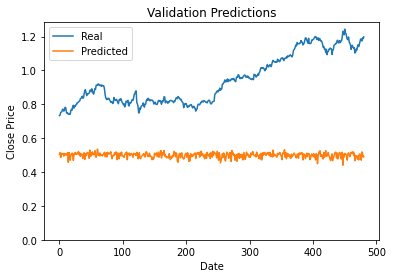


[10/100000]	Discriminator Loss: 1.3784	Generator Loss: 0.7065   	RMSE:1.0229
close | Real:0.3996 / Generated:0.5243
open | Real:0.3957 / Generated:-0.4289
high | Real:0.3983 / Generated:-0.4505
low | Real:0.4028 / Generated:-0.2571
CUMLOGRET_1 | Real:0.6851 / Generated:-0.1047
RSI_14 | Real:0.2999 / Generated:0.4693
MACD_12_26_9 | Real:0.4153 / Generated:0.0641
SMA5 | Real:0.4147 / Generated:-0.1360


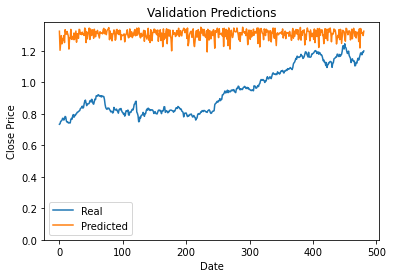


[15/100000]	Discriminator Loss: 1.2701	Generator Loss: 0.9531   	RMSE:0.5777
close | Real:0.1987 / Generated:1.0722
open | Real:0.1912 / Generated:0.6002
high | Real:0.1963 / Generated:0.4515
low | Real:0.1979 / Generated:-0.4763
CUMLOGRET_1 | Real:0.4755 / Generated:-0.1291
RSI_14 | Real:0.4259 / Generated:0.6482
MACD_12_26_9 | Real:0.5138 / Generated:0.7727
SMA5 | Real:0.1961 / Generated:1.0123


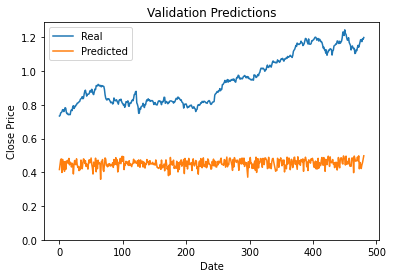


[20/100000]	Discriminator Loss: 1.2865	Generator Loss: 0.9413   	RMSE:0.3263
close | Real:0.0491 / Generated:0.1470
open | Real:0.0494 / Generated:0.0793
high | Real:0.0468 / Generated:-0.2975
low | Real:0.0532 / Generated:-0.1766
CUMLOGRET_1 | Real:0.1806 / Generated:0.4176
RSI_14 | Real:0.6449 / Generated:0.5735
MACD_12_26_9 | Real:0.6087 / Generated:0.3105
SMA5 | Real:0.0453 / Generated:0.1988


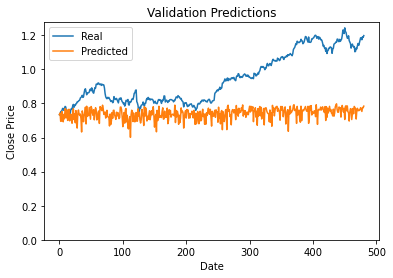


[25/100000]	Discriminator Loss: 1.3664	Generator Loss: 0.6556   	RMSE:0.1897
close | Real:0.4189 / Generated:0.6258
open | Real:0.4133 / Generated:0.6642
high | Real:0.4191 / Generated:0.5534
low | Real:0.4192 / Generated:0.6167
CUMLOGRET_1 | Real:0.7003 / Generated:0.7094
RSI_14 | Real:0.5886 / Generated:0.6798
MACD_12_26_9 | Real:0.6203 / Generated:0.5823
SMA5 | Real:0.4179 / Generated:0.4723


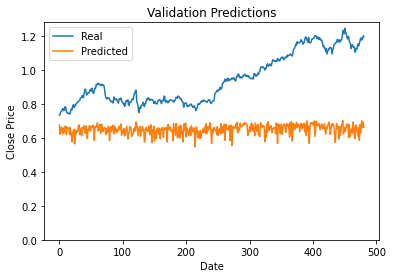


[30/100000]	Discriminator Loss: 1.3794	Generator Loss: 0.6195   	RMSE:0.2341
close | Real:0.6689 / Generated:0.6048
open | Real:0.6709 / Generated:0.5127
high | Real:0.6707 / Generated:0.6329
low | Real:0.6809 / Generated:0.7037
CUMLOGRET_1 | Real:0.8578 / Generated:0.8523
RSI_14 | Real:0.6345 / Generated:0.4029
MACD_12_26_9 | Real:0.7630 / Generated:0.7210
SMA5 | Real:0.6815 / Generated:0.6736


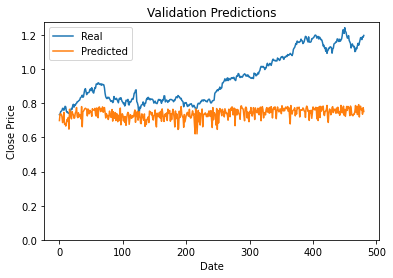


[35/100000]	Discriminator Loss: 1.2880	Generator Loss: 1.3015   	RMSE:0.2110
close | Real:0.3443 / Generated:0.4394
open | Real:0.3473 / Generated:0.4021
high | Real:0.3469 / Generated:0.3911
low | Real:0.3499 / Generated:0.3856
CUMLOGRET_1 | Real:0.6377 / Generated:0.5857
RSI_14 | Real:0.6308 / Generated:0.5460
MACD_12_26_9 | Real:0.7122 / Generated:0.5412
SMA5 | Real:0.3504 / Generated:0.2985


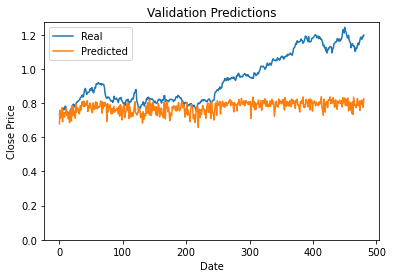


[40/100000]	Discriminator Loss: 1.2569	Generator Loss: 1.1168   	RMSE:0.1828
close | Real:0.5955 / Generated:0.6946
open | Real:0.5936 / Generated:0.6339
high | Real:0.5939 / Generated:0.6204
low | Real:0.6027 / Generated:0.6303
CUMLOGRET_1 | Real:0.8178 / Generated:0.9182
RSI_14 | Real:0.4455 / Generated:0.5317
MACD_12_26_9 | Real:0.6574 / Generated:0.5633
SMA5 | Real:0.6127 / Generated:0.7256


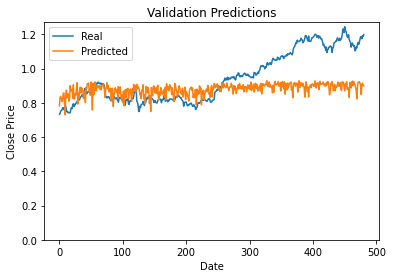


[45/100000]	Discriminator Loss: 1.0341	Generator Loss: 1.9580   	RMSE:0.1743
close | Real:0.7886 / Generated:0.8759
open | Real:0.8083 / Generated:0.9585
high | Real:0.8055 / Generated:1.0003
low | Real:0.8034 / Generated:0.8631
CUMLOGRET_1 | Real:0.9154 / Generated:1.2145
RSI_14 | Real:0.2371 / Generated:0.5188
MACD_12_26_9 | Real:0.4969 / Generated:0.4925
SMA5 | Real:0.8340 / Generated:0.8364


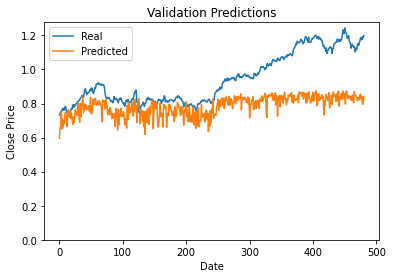


[50/100000]	Discriminator Loss: 1.0211	Generator Loss: 1.7456   	RMSE:0.1599
close | Real:0.0345 / Generated:-0.0416
open | Real:0.0379 / Generated:0.0517
high | Real:0.0352 / Generated:0.0701
low | Real:0.0382 / Generated:0.0729
CUMLOGRET_1 | Real:0.1350 / Generated:0.1508
RSI_14 | Real:0.3482 / Generated:0.2842
MACD_12_26_9 | Real:0.5080 / Generated:0.4104
SMA5 | Real:0.0327 / Generated:0.1517


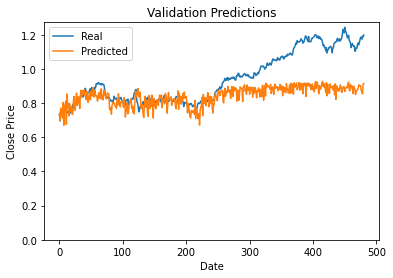


[55/100000]	Discriminator Loss: 1.2153	Generator Loss: 1.0156   	RMSE:0.1362
close | Real:0.0428 / Generated:0.0138
open | Real:0.0356 / Generated:0.0322
high | Real:0.0430 / Generated:0.0171
low | Real:0.0400 / Generated:0.0308
CUMLOGRET_1 | Real:0.1618 / Generated:0.1463
RSI_14 | Real:0.7665 / Generated:0.5262
MACD_12_26_9 | Real:0.6438 / Generated:0.6091
SMA5 | Real:0.0345 / Generated:0.0307


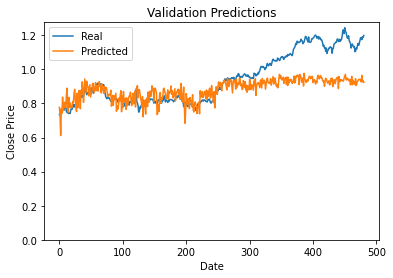


[60/100000]	Discriminator Loss: 1.2552	Generator Loss: 1.4949   	RMSE:0.1471
close | Real:0.0379 / Generated:0.0475
open | Real:0.0400 / Generated:0.0777
high | Real:0.0370 / Generated:0.0463
low | Real:0.0416 / Generated:0.0674
CUMLOGRET_1 | Real:0.1461 / Generated:0.1664
RSI_14 | Real:0.5637 / Generated:0.5035
MACD_12_26_9 | Real:0.6290 / Generated:0.5649
SMA5 | Real:0.0366 / Generated:0.0322


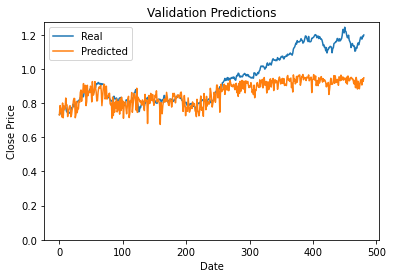


[65/100000]	Discriminator Loss: 1.0978	Generator Loss: 1.4742   	RMSE:0.1317
close | Real:0.0318 / Generated:0.0164
open | Real:0.0287 / Generated:0.0571
high | Real:0.0282 / Generated:0.0436
low | Real:0.0321 / Generated:0.0606
CUMLOGRET_1 | Real:0.1260 / Generated:0.1571
RSI_14 | Real:0.5328 / Generated:0.5321
MACD_12_26_9 | Real:0.5730 / Generated:0.6362
SMA5 | Real:0.0266 / Generated:0.0222


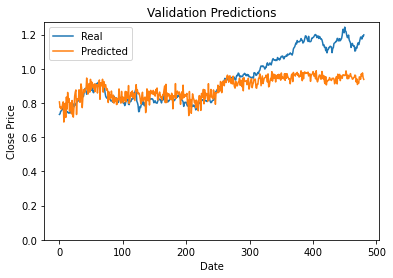


[70/100000]	Discriminator Loss: 0.8714	Generator Loss: 2.8161   	RMSE:0.1432
close | Real:0.5988 / Generated:0.6484
open | Real:0.5940 / Generated:0.6222
high | Real:0.6021 / Generated:0.5736
low | Real:0.6040 / Generated:0.5794
CUMLOGRET_1 | Real:0.8197 / Generated:0.7548
RSI_14 | Real:0.1750 / Generated:0.5036
MACD_12_26_9 | Real:0.3419 / Generated:0.5006
SMA5 | Real:0.6256 / Generated:0.6507


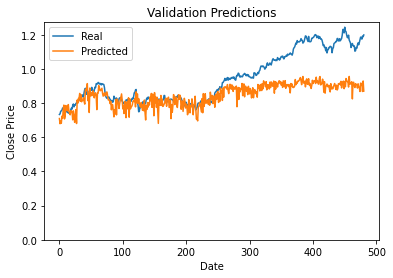


[75/100000]	Discriminator Loss: 1.1920	Generator Loss: 2.3250   	RMSE:0.1349
close | Real:0.0396 / Generated:0.0072
open | Real:0.0404 / Generated:0.0419
high | Real:0.0380 / Generated:0.0392
low | Real:0.0438 / Generated:0.0738
CUMLOGRET_1 | Real:0.1516 / Generated:0.1713
RSI_14 | Real:0.5417 / Generated:0.5217
MACD_12_26_9 | Real:0.5960 / Generated:0.5909
SMA5 | Real:0.0380 / Generated:0.0020


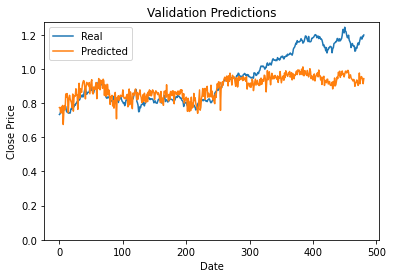


[80/100000]	Discriminator Loss: 0.9407	Generator Loss: 2.5284   	RMSE:0.1194
close | Real:0.2284 / Generated:0.2056
open | Real:0.2262 / Generated:0.1928
high | Real:0.2252 / Generated:0.1805
low | Real:0.2327 / Generated:0.1776
CUMLOGRET_1 | Real:0.5145 / Generated:0.4333
RSI_14 | Real:0.6614 / Generated:0.6937
MACD_12_26_9 | Real:0.6690 / Generated:0.7359
SMA5 | Real:0.2301 / Generated:0.1906


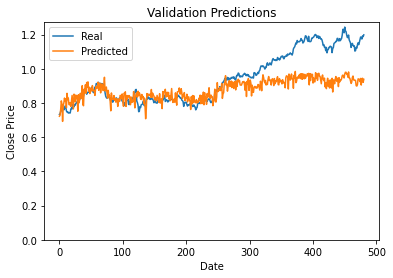


[85/100000]	Discriminator Loss: 1.1047	Generator Loss: 1.8454   	RMSE:0.1193
close | Real:0.7839 / Generated:0.8125
open | Real:0.7923 / Generated:0.7698
high | Real:0.7926 / Generated:0.9029
low | Real:0.7955 / Generated:0.8593
CUMLOGRET_1 | Real:0.9133 / Generated:0.8460
RSI_14 | Real:0.1871 / Generated:0.3859
MACD_12_26_9 | Real:0.4031 / Generated:0.4824
SMA5 | Real:0.8144 / Generated:0.8002


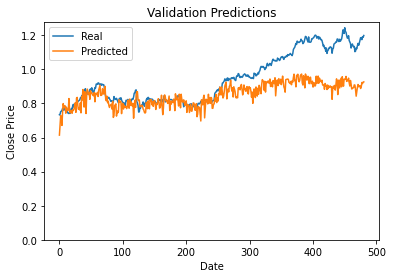


[90/100000]	Discriminator Loss: 0.8859	Generator Loss: 2.3570   	RMSE:0.1180
close | Real:0.4108 / Generated:0.3832
open | Real:0.4153 / Generated:0.3950
high | Real:0.4129 / Generated:0.3783
low | Real:0.4190 / Generated:0.3774
CUMLOGRET_1 | Real:0.6941 / Generated:0.7220
RSI_14 | Real:0.4909 / Generated:0.5701
MACD_12_26_9 | Real:0.5927 / Generated:0.6535
SMA5 | Real:0.4127 / Generated:0.4429


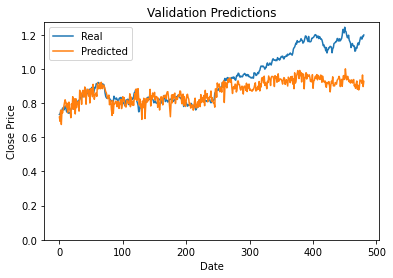


[95/100000]	Discriminator Loss: 1.7192	Generator Loss: 1.0812   	RMSE:0.1323
close | Real:0.0314 / Generated:0.0215
open | Real:0.0276 / Generated:0.0157
high | Real:0.0284 / Generated:0.0558
low | Real:0.0291 / Generated:0.0465
CUMLOGRET_1 | Real:0.1246 / Generated:0.1242
RSI_14 | Real:0.4516 / Generated:0.4173
MACD_12_26_9 | Real:0.5327 / Generated:0.5894
SMA5 | Real:0.0282 / Generated:-0.0226


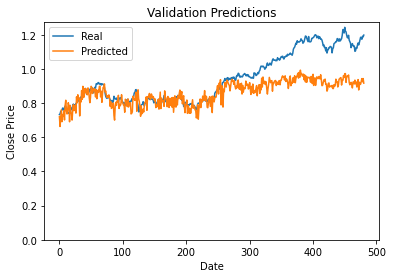


[100/100000]	Discriminator Loss: 0.9013	Generator Loss: 1.4729   	RMSE:0.1347
close | Real:0.0574 / Generated:0.0234
open | Real:0.0653 / Generated:0.0669
high | Real:0.0616 / Generated:0.0623
low | Real:0.0612 / Generated:0.0674
CUMLOGRET_1 | Real:0.2044 / Generated:0.1625
RSI_14 | Real:0.6739 / Generated:0.9024
MACD_12_26_9 | Real:0.7299 / Generated:0.7817
SMA5 | Real:0.0622 / Generated:0.0562


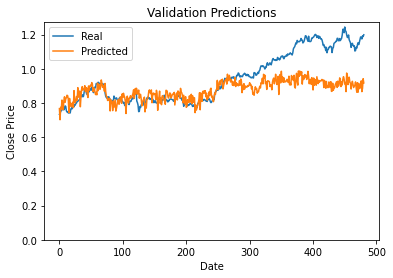


[105/100000]	Discriminator Loss: 0.7703	Generator Loss: 3.4153   	RMSE:0.1267
close | Real:0.8699 / Generated:0.8825
open | Real:0.8641 / Generated:0.8449
high | Real:0.8699 / Generated:0.9949
low | Real:0.8769 / Generated:0.9370
CUMLOGRET_1 | Real:0.9501 / Generated:0.9786
RSI_14 | Real:0.8607 / Generated:0.8463
MACD_12_26_9 | Real:0.8681 / Generated:0.7460
SMA5 | Real:0.8736 / Generated:0.8930


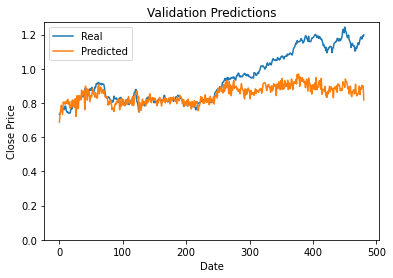


[110/100000]	Discriminator Loss: 0.9319	Generator Loss: 3.6463   	RMSE:0.1319
close | Real:0.3636 / Generated:0.4186
open | Real:0.3736 / Generated:0.4375
high | Real:0.3703 / Generated:0.3695
low | Real:0.3713 / Generated:0.3736
CUMLOGRET_1 | Real:0.6549 / Generated:0.6978
RSI_14 | Real:0.4044 / Generated:0.5443
MACD_12_26_9 | Real:0.6252 / Generated:0.6300
SMA5 | Real:0.3769 / Generated:0.4073


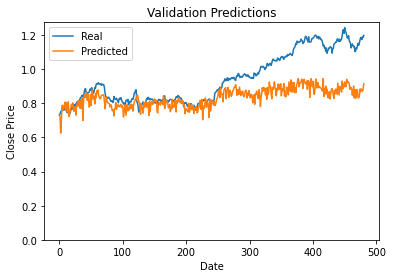


[115/100000]	Discriminator Loss: 0.9172	Generator Loss: 2.1232   	RMSE:0.1386
close | Real:0.2068 / Generated:0.1895
open | Real:0.2088 / Generated:0.1903
high | Real:0.2052 / Generated:0.1800
low | Real:0.2120 / Generated:0.1670
CUMLOGRET_1 | Real:0.4865 / Generated:0.4818
RSI_14 | Real:0.5186 / Generated:0.4597
MACD_12_26_9 | Real:0.5531 / Generated:0.5553
SMA5 | Real:0.2034 / Generated:0.2097


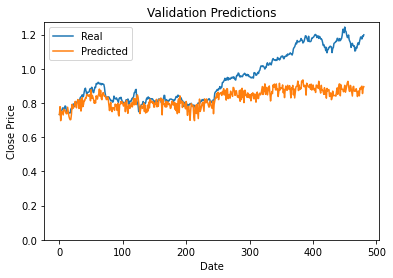


[120/100000]	Discriminator Loss: 1.1817	Generator Loss: 2.1373   	RMSE:0.1325
close | Real:0.0647 / Generated:0.0526
open | Real:0.0587 / Generated:0.0816
high | Real:0.0621 / Generated:0.0563
low | Real:0.0625 / Generated:0.0473
CUMLOGRET_1 | Real:0.2242 / Generated:0.1873
RSI_14 | Real:0.7812 / Generated:0.7766
MACD_12_26_9 | Real:0.7616 / Generated:0.6875
SMA5 | Real:0.0592 / Generated:0.0888


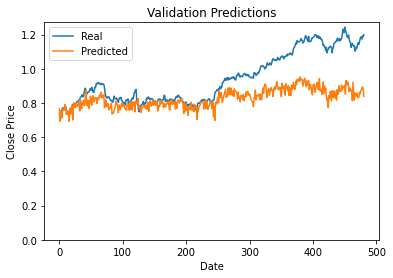


[125/100000]	Discriminator Loss: 0.7654	Generator Loss: 2.5672   	RMSE:0.1408
close | Real:0.3460 / Generated:0.3609
open | Real:0.3504 / Generated:0.3390
high | Real:0.3490 / Generated:0.3111
low | Real:0.3532 / Generated:0.3031
CUMLOGRET_1 | Real:0.6393 / Generated:0.6501
RSI_14 | Real:0.4523 / Generated:0.4569
MACD_12_26_9 | Real:0.5798 / Generated:0.5647
SMA5 | Real:0.3472 / Generated:0.3713


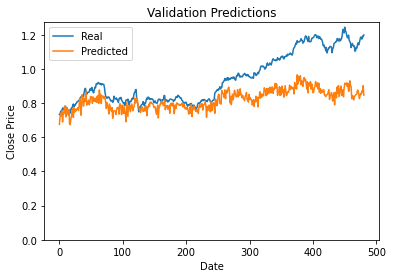


[130/100000]	Discriminator Loss: 1.2139	Generator Loss: 2.7813   	RMSE:0.1355
close | Real:0.0258 / Generated:0.0507
open | Real:0.0281 / Generated:0.0592
high | Real:0.0246 / Generated:0.0324
low | Real:0.0287 / Generated:0.0330
CUMLOGRET_1 | Real:0.1053 / Generated:0.1604
RSI_14 | Real:0.3665 / Generated:0.4747
MACD_12_26_9 | Real:0.5602 / Generated:0.5654
SMA5 | Real:0.0266 / Generated:0.0407


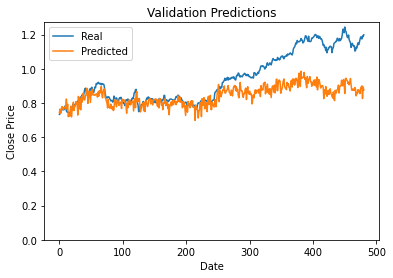


[135/100000]	Discriminator Loss: 1.0955	Generator Loss: 2.6674   	RMSE:0.1482
close | Real:0.3483 / Generated:0.3625
open | Real:0.3488 / Generated:0.3619
high | Real:0.3472 / Generated:0.3398
low | Real:0.3544 / Generated:0.3432
CUMLOGRET_1 | Real:0.6413 / Generated:0.6552
RSI_14 | Real:0.5490 / Generated:0.6386
MACD_12_26_9 | Real:0.6737 / Generated:0.6679
SMA5 | Real:0.3547 / Generated:0.3869


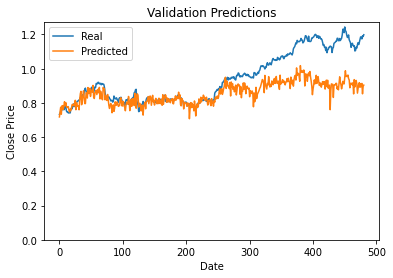


[140/100000]	Discriminator Loss: 0.8750	Generator Loss: 3.1481   	RMSE:0.1290
close | Real:0.0396 / Generated:0.0416
open | Real:0.0404 / Generated:0.0636
high | Real:0.0380 / Generated:0.0566
low | Real:0.0438 / Generated:0.0338
CUMLOGRET_1 | Real:0.1516 / Generated:0.1586
RSI_14 | Real:0.5417 / Generated:0.4663
MACD_12_26_9 | Real:0.5960 / Generated:0.6207
SMA5 | Real:0.0380 / Generated:0.0377


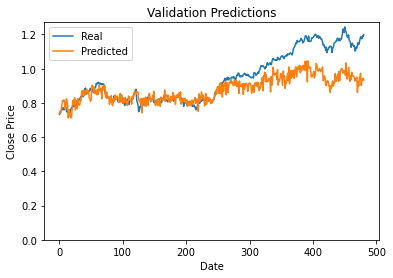


[145/100000]	Discriminator Loss: 0.9857	Generator Loss: 2.6933   	RMSE:0.1282
close | Real:0.5584 / Generated:0.5815
open | Real:0.5560 / Generated:0.5706
high | Real:0.5576 / Generated:0.4820
low | Real:0.5646 / Generated:0.5484
CUMLOGRET_1 | Real:0.7959 / Generated:0.7610
RSI_14 | Real:0.5326 / Generated:0.3640
MACD_12_26_9 | Real:0.4787 / Generated:0.5887
SMA5 | Real:0.5534 / Generated:0.5178


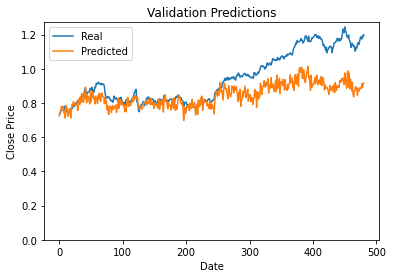


[150/100000]	Discriminator Loss: 0.9782	Generator Loss: 2.2279   	RMSE:0.1196
close | Real:0.6014 / Generated:0.5761
open | Real:0.6000 / Generated:0.6103
high | Real:0.6009 / Generated:0.5513
low | Real:0.6080 / Generated:0.5532
CUMLOGRET_1 | Real:0.8212 / Generated:0.7758
RSI_14 | Real:0.4932 / Generated:0.4216
MACD_12_26_9 | Real:0.6158 / Generated:0.6628
SMA5 | Real:0.6128 / Generated:0.5340


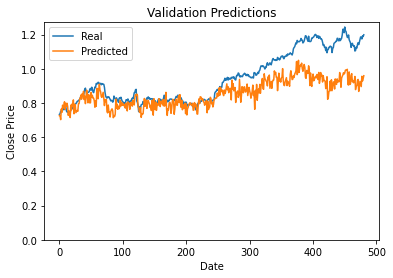


[155/100000]	Discriminator Loss: 1.1987	Generator Loss: 2.3074   	RMSE:0.1087
close | Real:0.8159 / Generated:0.7713
open | Real:0.8148 / Generated:0.8194
high | Real:0.8151 / Generated:0.8870
low | Real:0.8216 / Generated:0.8404
CUMLOGRET_1 | Real:0.9274 / Generated:0.8801
RSI_14 | Real:0.3356 / Generated:0.3069
MACD_12_26_9 | Real:0.4629 / Generated:0.4180
SMA5 | Real:0.8305 / Generated:0.8931


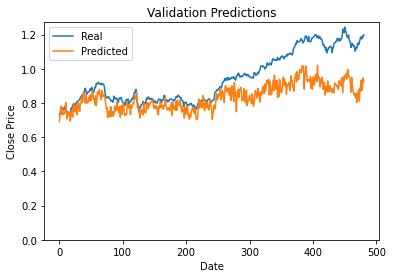


[160/100000]	Discriminator Loss: 1.2304	Generator Loss: 1.1446   	RMSE:0.1161
close | Real:0.8353 / Generated:0.8224
open | Real:0.8407 / Generated:0.8017
high | Real:0.8408 / Generated:0.9237
low | Real:0.8458 / Generated:0.9026
CUMLOGRET_1 | Real:0.9357 / Generated:0.8984
RSI_14 | Real:0.5673 / Generated:0.7115
MACD_12_26_9 | Real:0.8203 / Generated:0.8082
SMA5 | Real:0.8620 / Generated:0.8427


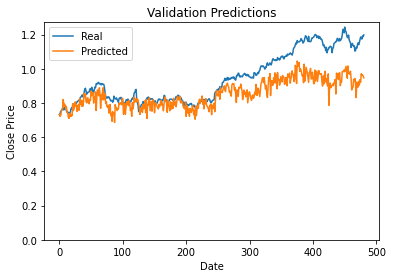


[165/100000]	Discriminator Loss: 0.8176	Generator Loss: 2.2837   	RMSE:0.1150
close | Real:0.6974 / Generated:0.6591
open | Real:0.6992 / Generated:0.6692
high | Real:0.6957 / Generated:0.6923
low | Real:0.7042 / Generated:0.6934
CUMLOGRET_1 | Real:0.8723 / Generated:0.7851
RSI_14 | Real:0.3881 / Generated:0.4060
MACD_12_26_9 | Real:0.5873 / Generated:0.6320
SMA5 | Real:0.7155 / Generated:0.6767


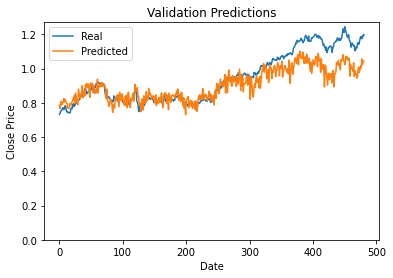


[170/100000]	Discriminator Loss: 1.1323	Generator Loss: 2.0306   	RMSE:0.1237
close | Real:0.4501 / Generated:0.5034
open | Real:0.4455 / Generated:0.4771
high | Real:0.4513 / Generated:0.3921
low | Real:0.4513 / Generated:0.4746
CUMLOGRET_1 | Real:0.7239 / Generated:0.7760
RSI_14 | Real:0.4889 / Generated:0.6629
MACD_12_26_9 | Real:0.4355 / Generated:0.4958
SMA5 | Real:0.4520 / Generated:0.4382


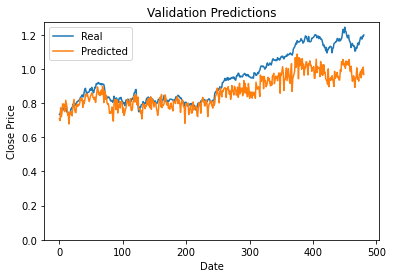


[175/100000]	Discriminator Loss: 1.0835	Generator Loss: 1.6668   	RMSE:0.1038
close | Real:0.8743 / Generated:0.7773
open | Real:0.8591 / Generated:0.8273
high | Real:0.8726 / Generated:0.9146
low | Real:0.8740 / Generated:0.8624
CUMLOGRET_1 | Real:0.9519 / Generated:0.8895
RSI_14 | Real:0.4956 / Generated:0.3612
MACD_12_26_9 | Real:0.5654 / Generated:0.5752
SMA5 | Real:0.8836 / Generated:0.9347


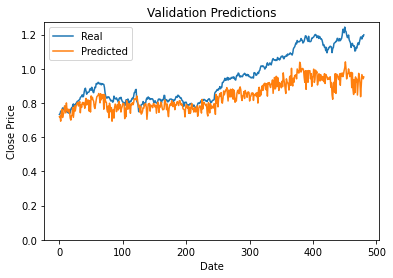


[180/100000]	Discriminator Loss: 1.0135	Generator Loss: 2.1463   	RMSE:0.1147
close | Real:0.6013 / Generated:0.5699
open | Real:0.5960 / Generated:0.6237
high | Real:0.6005 / Generated:0.6181
low | Real:0.6076 / Generated:0.6383
CUMLOGRET_1 | Real:0.8212 / Generated:0.8042
RSI_14 | Real:0.6587 / Generated:0.6066
MACD_12_26_9 | Real:0.7907 / Generated:0.7771
SMA5 | Real:0.6087 / Generated:0.5823


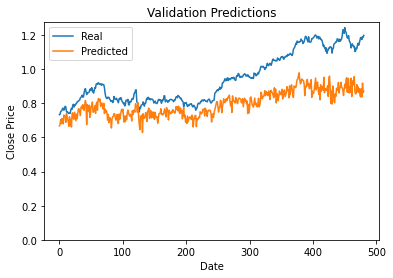


[185/100000]	Discriminator Loss: 0.8277	Generator Loss: 2.8975   	RMSE:0.1481
close | Real:0.0539 / Generated:0.0677
open | Real:0.0553 / Generated:0.0995
high | Real:0.0517 / Generated:0.0359
low | Real:0.0574 / Generated:0.1027
CUMLOGRET_1 | Real:0.1945 / Generated:0.1511
RSI_14 | Real:0.7334 / Generated:0.8156
MACD_12_26_9 | Real:0.6390 / Generated:0.6850
SMA5 | Real:0.0511 / Generated:0.0316


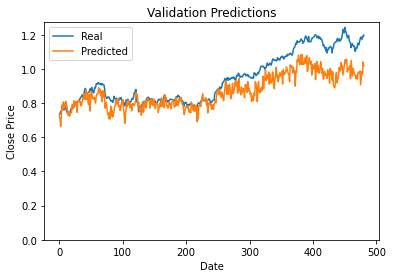


[190/100000]	Discriminator Loss: 0.8192	Generator Loss: 2.6211   	RMSE:0.1132
close | Real:0.7766 / Generated:0.7802
open | Real:0.7758 / Generated:0.7545
high | Real:0.7853 / Generated:0.7789
low | Real:0.7894 / Generated:0.7696
CUMLOGRET_1 | Real:0.9100 / Generated:0.8714
RSI_14 | Real:0.4541 / Generated:0.4735
MACD_12_26_9 | Real:0.5163 / Generated:0.4734
SMA5 | Real:0.7845 / Generated:0.7731


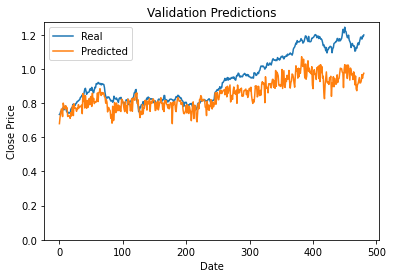


[195/100000]	Discriminator Loss: 1.1576	Generator Loss: 1.4431   	RMSE:0.1134
close | Real:0.3718 / Generated:0.3307
open | Real:0.3696 / Generated:0.3224
high | Real:0.3704 / Generated:0.3556
low | Real:0.3784 / Generated:0.3407
CUMLOGRET_1 | Real:0.6620 / Generated:0.6854
RSI_14 | Real:0.7279 / Generated:0.8384
MACD_12_26_9 | Real:0.7194 / Generated:0.7113
SMA5 | Real:0.3681 / Generated:0.3445


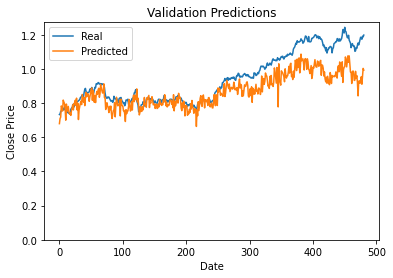


[200/100000]	Discriminator Loss: 0.9751	Generator Loss: 2.6170   	RMSE:0.1068
close | Real:0.7805 / Generated:0.7584
open | Real:0.7676 / Generated:0.7797
high | Real:0.7777 / Generated:0.8136
low | Real:0.7814 / Generated:0.7588
CUMLOGRET_1 | Real:0.9118 / Generated:0.8667
RSI_14 | Real:0.7536 / Generated:0.5021
MACD_12_26_9 | Real:0.7028 / Generated:0.7696
SMA5 | Real:0.7753 / Generated:0.7057


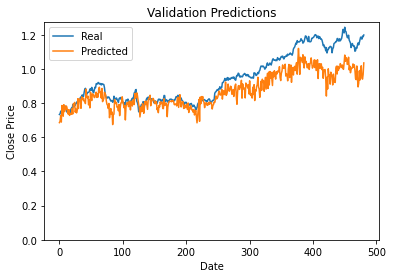


[205/100000]	Discriminator Loss: 1.1520	Generator Loss: 2.0549   	RMSE:0.1185
close | Real:0.1297 / Generated:0.1097
open | Real:0.1185 / Generated:0.1078
high | Real:0.1274 / Generated:0.1107
low | Real:0.1237 / Generated:0.1120
CUMLOGRET_1 | Real:0.3660 / Generated:0.3263
RSI_14 | Real:0.6777 / Generated:0.5495
MACD_12_26_9 | Real:0.6309 / Generated:0.6204
SMA5 | Real:0.1161 / Generated:0.1303


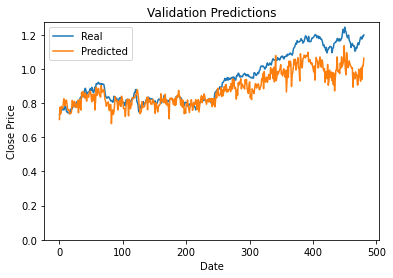


[210/100000]	Discriminator Loss: 1.0152	Generator Loss: 2.0600   	RMSE:0.1144
close | Real:0.5188 / Generated:0.4816
open | Real:0.5177 / Generated:0.5153
high | Real:0.5189 / Generated:0.5167
low | Real:0.5245 / Generated:0.5510
CUMLOGRET_1 | Real:0.7711 / Generated:0.7960
RSI_14 | Real:0.6958 / Generated:0.7920
MACD_12_26_9 | Real:0.7456 / Generated:0.7707
SMA5 | Real:0.5233 / Generated:0.5080


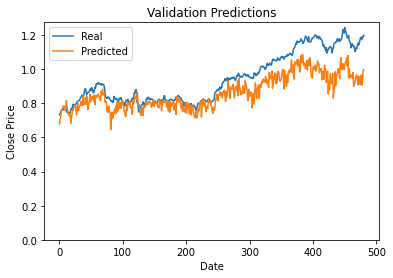


[215/100000]	Discriminator Loss: 1.0974	Generator Loss: 2.2992   	RMSE:0.1173
close | Real:0.5325 / Generated:0.4382
open | Real:0.5361 / Generated:0.5144
high | Real:0.5369 / Generated:0.5013
low | Real:0.5436 / Generated:0.5379
CUMLOGRET_1 | Real:0.7799 / Generated:0.7085
RSI_14 | Real:0.3279 / Generated:0.0821
MACD_12_26_9 | Real:0.2376 / Generated:0.2500
SMA5 | Real:0.5401 / Generated:0.5250


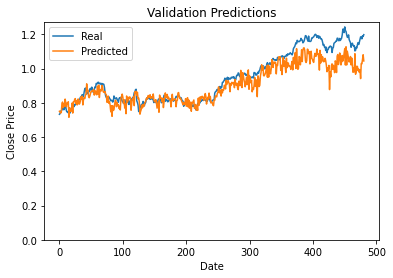


[220/100000]	Discriminator Loss: 1.0159	Generator Loss: 2.0595   	RMSE:0.1109
close | Real:0.1012 / Generated:0.1010
open | Real:0.1054 / Generated:0.0937
high | Real:0.1017 / Generated:0.1209
low | Real:0.0988 / Generated:0.1144
CUMLOGRET_1 | Real:0.3100 / Generated:0.3325
RSI_14 | Real:0.4088 / Generated:0.4086
MACD_12_26_9 | Real:0.5705 / Generated:0.5775
SMA5 | Real:0.1000 / Generated:0.1358


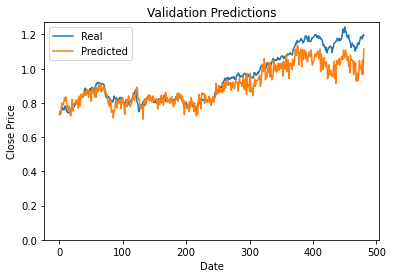


[225/100000]	Discriminator Loss: 0.9749	Generator Loss: 2.0187   	RMSE:0.1060
close | Real:0.8064 / Generated:0.8279
open | Real:0.8120 / Generated:0.7706
high | Real:0.8149 / Generated:0.8885
low | Real:0.8187 / Generated:0.8554
CUMLOGRET_1 | Real:0.9233 / Generated:0.9278
RSI_14 | Real:0.6341 / Generated:0.6904
MACD_12_26_9 | Real:0.8473 / Generated:0.7719
SMA5 | Real:0.8264 / Generated:0.8166


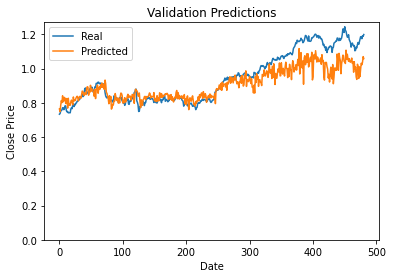


[230/100000]	Discriminator Loss: 1.3047	Generator Loss: 0.8826   	RMSE:0.1330
close | Real:0.0473 / Generated:0.0502
open | Real:0.0559 / Generated:0.0731
high | Real:0.0524 / Generated:0.0599
low | Real:0.0513 / Generated:0.0552
CUMLOGRET_1 | Real:0.1754 / Generated:0.1856
RSI_14 | Real:0.4483 / Generated:0.5732
MACD_12_26_9 | Real:0.6536 / Generated:0.6814
SMA5 | Real:0.0526 / Generated:0.0579


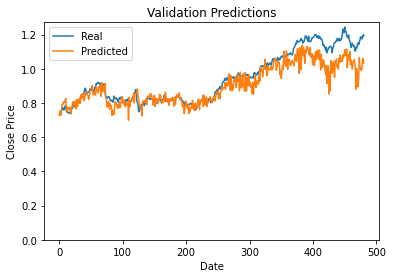


[235/100000]	Discriminator Loss: 1.4977	Generator Loss: 2.2992   	RMSE:0.1176
close | Real:0.7317 / Generated:0.6693
open | Real:0.7244 / Generated:0.6801
high | Real:0.7343 / Generated:0.7368
low | Real:0.7289 / Generated:0.7368
CUMLOGRET_1 | Real:0.8891 / Generated:0.8704
RSI_14 | Real:0.8616 / Generated:0.7760
MACD_12_26_9 | Real:0.9265 / Generated:0.8530
SMA5 | Real:0.7382 / Generated:0.6532


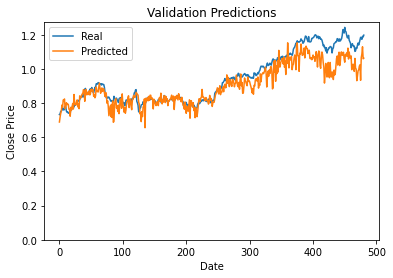


[240/100000]	Discriminator Loss: 0.9288	Generator Loss: 2.3686   	RMSE:0.1188
close | Real:0.0215 / Generated:0.0347
open | Real:0.0287 / Generated:0.0344
high | Real:0.0250 / Generated:0.0113
low | Real:0.0199 / Generated:0.0391
CUMLOGRET_1 | Real:0.0896 / Generated:0.1041
RSI_14 | Real:0.3381 / Generated:0.4239
MACD_12_26_9 | Real:0.4414 / Generated:0.5243
SMA5 | Real:0.0242 / Generated:0.0317


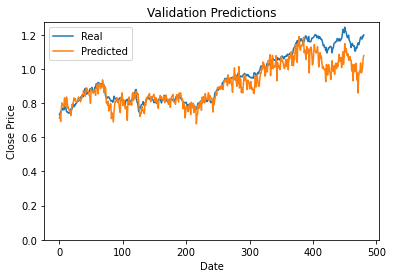


[245/100000]	Discriminator Loss: 1.2182	Generator Loss: 1.5178   	RMSE:0.1129
close | Real:0.3483 / Generated:0.3441
open | Real:0.3488 / Generated:0.3402
high | Real:0.3472 / Generated:0.3467
low | Real:0.3544 / Generated:0.3266
CUMLOGRET_1 | Real:0.6413 / Generated:0.6292
RSI_14 | Real:0.5490 / Generated:0.5860
MACD_12_26_9 | Real:0.6737 / Generated:0.6899
SMA5 | Real:0.3547 / Generated:0.3303


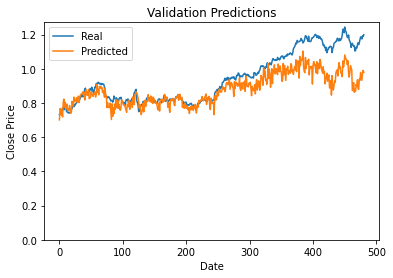


[250/100000]	Discriminator Loss: 1.2976	Generator Loss: 1.2312   	RMSE:0.1239
close | Real:0.4196 / Generated:0.4445
open | Real:0.4118 / Generated:0.4576
high | Real:0.4191 / Generated:0.4340
low | Real:0.4212 / Generated:0.4458
CUMLOGRET_1 | Real:0.7009 / Generated:0.7251
RSI_14 | Real:0.7068 / Generated:0.6439
MACD_12_26_9 | Real:0.7241 / Generated:0.7483
SMA5 | Real:0.4140 / Generated:0.4226


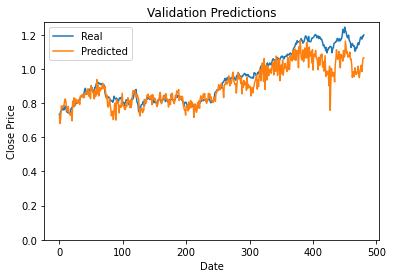


[255/100000]	Discriminator Loss: 0.9683	Generator Loss: 1.7416   	RMSE:0.1192
close | Real:0.5278 / Generated:0.5263
open | Real:0.5271 / Generated:0.5583
high | Real:0.5254 / Generated:0.4968
low | Real:0.5349 / Generated:0.5410
CUMLOGRET_1 | Real:0.7769 / Generated:0.7579
RSI_14 | Real:0.4593 / Generated:0.3977
MACD_12_26_9 | Real:0.4849 / Generated:0.4563
SMA5 | Real:0.5296 / Generated:0.5485


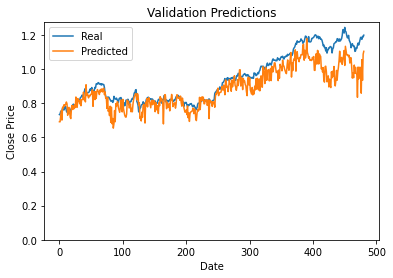


[260/100000]	Discriminator Loss: 1.1054	Generator Loss: 2.3506   	RMSE:0.1281
close | Real:0.6754 / Generated:0.6680
open | Real:0.6767 / Generated:0.6857
high | Real:0.6792 / Generated:0.6238
low | Real:0.6873 / Generated:0.6375
CUMLOGRET_1 | Real:0.8612 / Generated:0.8099
RSI_14 | Real:0.5953 / Generated:0.5079
MACD_12_26_9 | Real:0.6232 / Generated:0.5651
SMA5 | Real:0.6803 / Generated:0.6388


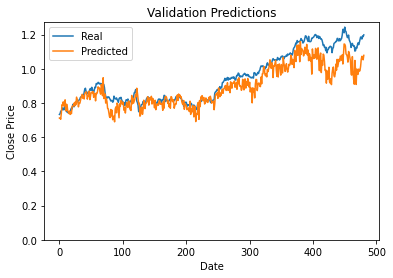


[265/100000]	Discriminator Loss: 1.0375	Generator Loss: 1.9101   	RMSE:0.1217
close | Real:0.4594 / Generated:0.4639
open | Real:0.4551 / Generated:0.4644
high | Real:0.4600 / Generated:0.4521
low | Real:0.4648 / Generated:0.4662
CUMLOGRET_1 | Real:0.7306 / Generated:0.7415
RSI_14 | Real:0.6152 / Generated:0.6655
MACD_12_26_9 | Real:0.6970 / Generated:0.6892
SMA5 | Real:0.4589 / Generated:0.4494


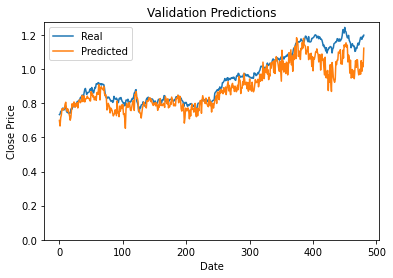


[270/100000]	Discriminator Loss: 1.0303	Generator Loss: 2.5214   	RMSE:0.1163
close | Real:0.5150 / Generated:0.4729
open | Real:0.5148 / Generated:0.5134
high | Real:0.5131 / Generated:0.5113
low | Real:0.5217 / Generated:0.5047
CUMLOGRET_1 | Real:0.7686 / Generated:0.7574
RSI_14 | Real:0.6756 / Generated:0.6805
MACD_12_26_9 | Real:0.7375 / Generated:0.7661
SMA5 | Real:0.5183 / Generated:0.4720


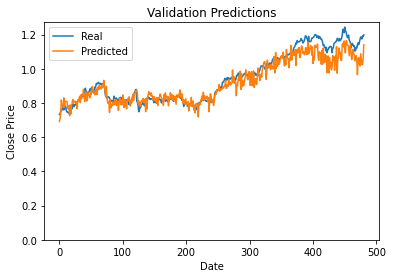


[275/100000]	Discriminator Loss: 1.0880	Generator Loss: 1.7015   	RMSE:0.1178
close | Real:0.8866 / Generated:0.8150
open | Real:0.8815 / Generated:0.8557
high | Real:0.8878 / Generated:0.8352
low | Real:0.8967 / Generated:0.8138
CUMLOGRET_1 | Real:0.9569 / Generated:0.9419
RSI_14 | Real:0.5521 / Generated:0.4897
MACD_12_26_9 | Real:0.4957 / Generated:0.4600
SMA5 | Real:0.8820 / Generated:0.8502


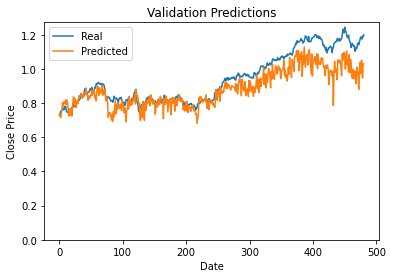


[280/100000]	Discriminator Loss: 0.9719	Generator Loss: 1.6022   	RMSE:0.1331
close | Real:0.7394 / Generated:0.7280
open | Real:0.7468 / Generated:0.7560
high | Real:0.7433 / Generated:0.7089
low | Real:0.7511 / Generated:0.7370
CUMLOGRET_1 | Real:0.8928 / Generated:0.8753
RSI_14 | Real:0.7284 / Generated:0.6875
MACD_12_26_9 | Real:0.7658 / Generated:0.7895
SMA5 | Real:0.7516 / Generated:0.6814


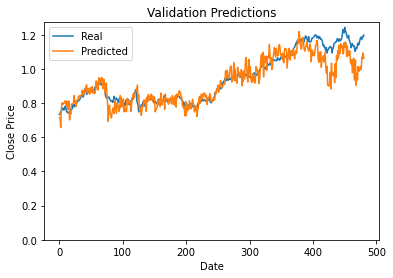


[285/100000]	Discriminator Loss: 1.1449	Generator Loss: 1.5852   	RMSE:0.1201
close | Real:0.5447 / Generated:0.5326
open | Real:0.5487 / Generated:0.5819
high | Real:0.5489 / Generated:0.5189
low | Real:0.5522 / Generated:0.5364
CUMLOGRET_1 | Real:0.7875 / Generated:0.7720
RSI_14 | Real:0.4863 / Generated:0.4902
MACD_12_26_9 | Real:0.5199 / Generated:0.5095
SMA5 | Real:0.5500 / Generated:0.5397


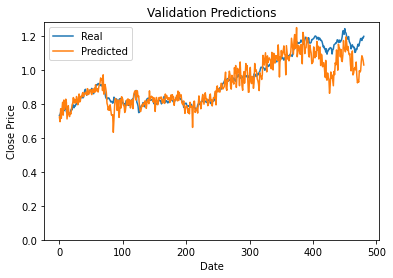


[290/100000]	Discriminator Loss: 1.1379	Generator Loss: 1.7983   	RMSE:0.1214
close | Real:0.7358 / Generated:0.6785
open | Real:0.7270 / Generated:0.6974
high | Real:0.7334 / Generated:0.7443
low | Real:0.7364 / Generated:0.7124
CUMLOGRET_1 | Real:0.8910 / Generated:0.8985
RSI_14 | Real:0.7903 / Generated:0.7865
MACD_12_26_9 | Real:0.9130 / Generated:0.8774
SMA5 | Real:0.7430 / Generated:0.7091


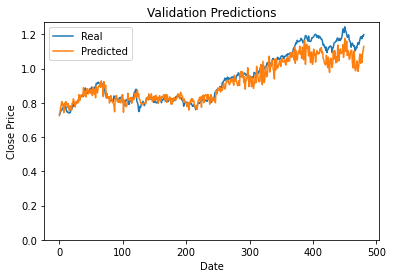


[295/100000]	Discriminator Loss: 1.2459	Generator Loss: 0.8361   	RMSE:0.1328
close | Real:0.1817 / Generated:0.1573
open | Real:0.1838 / Generated:0.1584
high | Real:0.1835 / Generated:0.1650
low | Real:0.1870 / Generated:0.1562
CUMLOGRET_1 | Real:0.4512 / Generated:0.3923
RSI_14 | Real:0.6825 / Generated:0.5465
MACD_12_26_9 | Real:0.6785 / Generated:0.6365
SMA5 | Real:0.1774 / Generated:0.1714


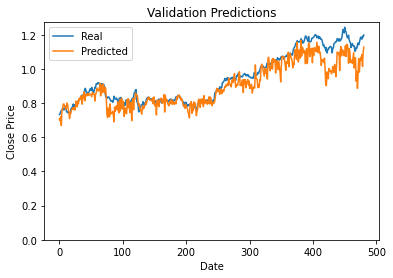


[300/100000]	Discriminator Loss: 0.9843	Generator Loss: 1.5552   	RMSE:0.1185
close | Real:0.4891 / Generated:0.4834
open | Real:0.4903 / Generated:0.5028
high | Real:0.4902 / Generated:0.4725
low | Real:0.4947 / Generated:0.4816
CUMLOGRET_1 | Real:0.7514 / Generated:0.7352
RSI_14 | Real:0.5047 / Generated:0.5831
MACD_12_26_9 | Real:0.5853 / Generated:0.6191
SMA5 | Real:0.4949 / Generated:0.4765


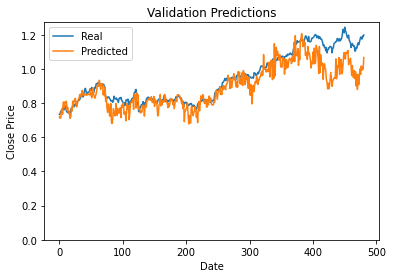


[305/100000]	Discriminator Loss: 0.9002	Generator Loss: 3.7525   	RMSE:0.1376
close | Real:0.3707 / Generated:0.3589
open | Real:0.3605 / Generated:0.3899
high | Real:0.3674 / Generated:0.3879
low | Real:0.3685 / Generated:0.3480
CUMLOGRET_1 | Real:0.6610 / Generated:0.6621
RSI_14 | Real:0.5449 / Generated:0.5194
MACD_12_26_9 | Real:0.5502 / Generated:0.4435
SMA5 | Real:0.3590 / Generated:0.3420


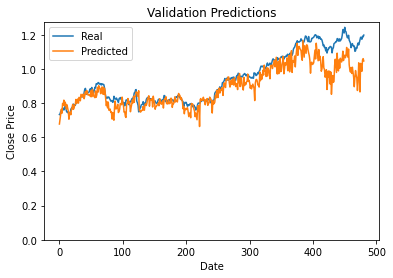


[310/100000]	Discriminator Loss: 1.4073	Generator Loss: 0.9056   	RMSE:0.1251
close | Real:0.4650 / Generated:0.4753
open | Real:0.4617 / Generated:0.4871
high | Real:0.4634 / Generated:0.4651
low | Real:0.4664 / Generated:0.4689
CUMLOGRET_1 | Real:0.7346 / Generated:0.7467
RSI_14 | Real:0.6479 / Generated:0.6517
MACD_12_26_9 | Real:0.7076 / Generated:0.7133
SMA5 | Real:0.4652 / Generated:0.4524


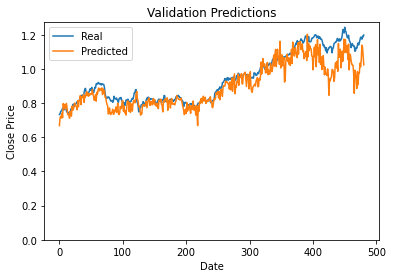


[315/100000]	Discriminator Loss: 1.1404	Generator Loss: 3.0427   	RMSE:0.1200
close | Real:0.8753 / Generated:0.7741
open | Real:0.8704 / Generated:0.8807
high | Real:0.8764 / Generated:0.8554
low | Real:0.8825 / Generated:0.8816
CUMLOGRET_1 | Real:0.9523 / Generated:1.0089
RSI_14 | Real:0.5100 / Generated:0.5563
MACD_12_26_9 | Real:0.4563 / Generated:0.3927
SMA5 | Real:0.8713 / Generated:0.8977


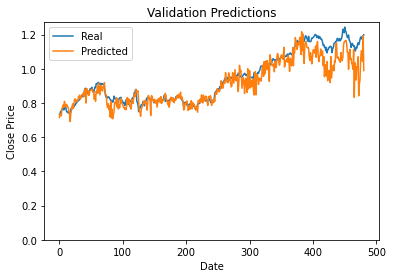


[320/100000]	Discriminator Loss: 1.2196	Generator Loss: 2.3032   	RMSE:0.1236
close | Real:0.1691 / Generated:0.1677
open | Real:0.1617 / Generated:0.1468
high | Real:0.1656 / Generated:0.1549
low | Real:0.1680 / Generated:0.1477
CUMLOGRET_1 | Real:0.4322 / Generated:0.3755
RSI_14 | Real:0.8196 / Generated:0.6331
MACD_12_26_9 | Real:0.6913 / Generated:0.6915
SMA5 | Real:0.1645 / Generated:0.1729


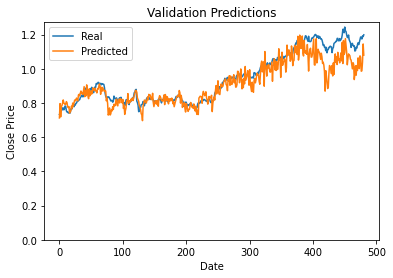


[325/100000]	Discriminator Loss: 1.1773	Generator Loss: 1.3788   	RMSE:0.1218
close | Real:0.0774 / Generated:0.0876
open | Real:0.0801 / Generated:0.0813
high | Real:0.0798 / Generated:0.0980
low | Real:0.0812 / Generated:0.0861
CUMLOGRET_1 | Real:0.2562 / Generated:0.2553
RSI_14 | Real:0.6302 / Generated:0.7524
MACD_12_26_9 | Real:0.7101 / Generated:0.6992
SMA5 | Real:0.0823 / Generated:0.0894


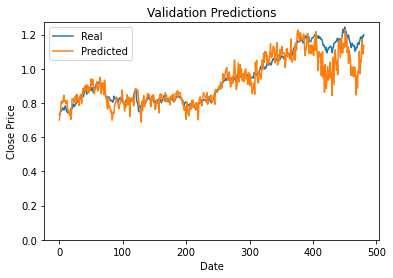


[330/100000]	Discriminator Loss: 1.2081	Generator Loss: 1.7617   	RMSE:0.1324
close | Real:0.3451 / Generated:0.3670
open | Real:0.3426 / Generated:0.3396
high | Real:0.3520 / Generated:0.3726
low | Real:0.3511 / Generated:0.3438
CUMLOGRET_1 | Real:0.6384 / Generated:0.6876
RSI_14 | Real:0.7200 / Generated:0.7708
MACD_12_26_9 | Real:0.7213 / Generated:0.7323
SMA5 | Real:0.3402 / Generated:0.3271


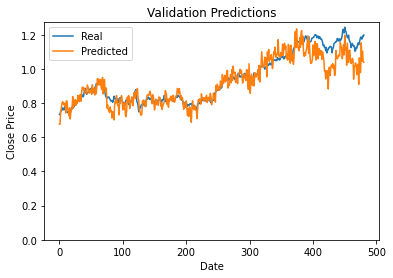


[335/100000]	Discriminator Loss: 0.8664	Generator Loss: 1.9877   	RMSE:0.1256
close | Real:0.5129 / Generated:0.5182
open | Real:0.4973 / Generated:0.5366
high | Real:0.5111 / Generated:0.5264
low | Real:0.5077 / Generated:0.5159
CUMLOGRET_1 | Real:0.7673 / Generated:0.7919
RSI_14 | Real:0.8488 / Generated:0.8638
MACD_12_26_9 | Real:0.7795 / Generated:0.8072
SMA5 | Real:0.5031 / Generated:0.4581


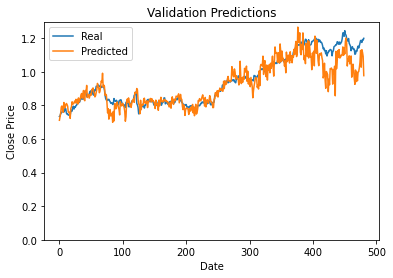


[340/100000]	Discriminator Loss: 1.1962	Generator Loss: 0.8637   	RMSE:0.1263
close | Real:0.4308 / Generated:0.4538
open | Real:0.4316 / Generated:0.4496
high | Real:0.4352 / Generated:0.4316
low | Real:0.4381 / Generated:0.4266
CUMLOGRET_1 | Real:0.7095 / Generated:0.7302
RSI_14 | Real:0.5170 / Generated:0.6025
MACD_12_26_9 | Real:0.6220 / Generated:0.6617
SMA5 | Real:0.4375 / Generated:0.4264


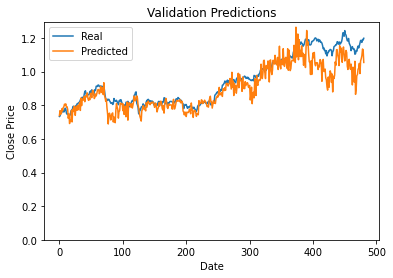


[345/100000]	Discriminator Loss: 0.8702	Generator Loss: 1.9519   	RMSE:0.1308
close | Real:0.0080 / Generated:-0.0520
open | Real:0.0066 / Generated:-0.0223
high | Real:0.0043 / Generated:0.0577
low | Real:0.0095 / Generated:-0.0112
CUMLOGRET_1 | Real:0.0356 / Generated:0.0505
RSI_14 | Real:0.3414 / Generated:0.1407
MACD_12_26_9 | Real:0.5037 / Generated:0.5011
SMA5 | Real:0.0017 / Generated:-0.0177


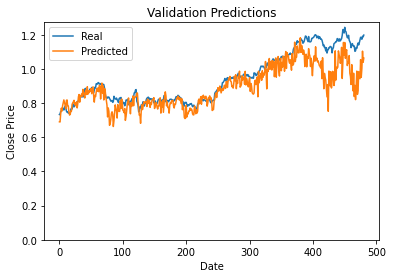


[350/100000]	Discriminator Loss: 1.1283	Generator Loss: 1.2305   	RMSE:0.1329
close | Real:0.1923 / Generated:0.1795
open | Real:0.1922 / Generated:0.1518
high | Real:0.1895 / Generated:0.2079
low | Real:0.1959 / Generated:0.1703
CUMLOGRET_1 | Real:0.4665 / Generated:0.4469
RSI_14 | Real:0.3467 / Generated:0.3123
MACD_12_26_9 | Real:0.5045 / Generated:0.4764
SMA5 | Real:0.1965 / Generated:0.2084


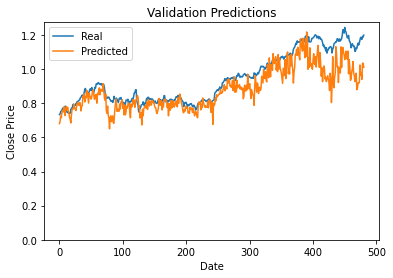


[355/100000]	Discriminator Loss: 1.0921	Generator Loss: 4.5070   	RMSE:0.1397
close | Real:0.2341 / Generated:0.2362
open | Real:0.2309 / Generated:0.1988
high | Real:0.2307 / Generated:0.2133
low | Real:0.2364 / Generated:0.2288
CUMLOGRET_1 | Real:0.5215 / Generated:0.5446
RSI_14 | Real:0.5281 / Generated:0.4894
MACD_12_26_9 | Real:0.6638 / Generated:0.6751
SMA5 | Real:0.2393 / Generated:0.2547


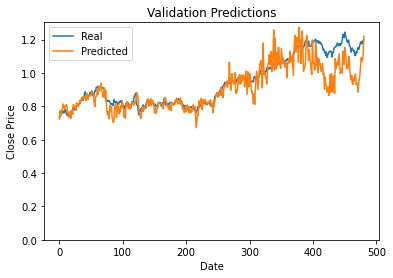


[360/100000]	Discriminator Loss: 0.9298	Generator Loss: 2.9233   	RMSE:0.1414
close | Real:0.7922 / Generated:0.7540
open | Real:0.8048 / Generated:0.7557
high | Real:0.8050 / Generated:0.7601
low | Real:0.8057 / Generated:0.7890
CUMLOGRET_1 | Real:0.9170 / Generated:0.8751
RSI_14 | Real:0.2856 / Generated:0.3275
MACD_12_26_9 | Real:0.3921 / Generated:0.3856
SMA5 | Real:0.8199 / Generated:0.8390


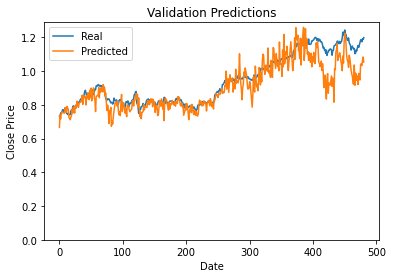


[365/100000]	Discriminator Loss: 0.9985	Generator Loss: 2.3492   	RMSE:0.1431
close | Real:0.4870 / Generated:0.4826
open | Real:0.4939 / Generated:0.5059
high | Real:0.4938 / Generated:0.4837
low | Real:0.4934 / Generated:0.4806
CUMLOGRET_1 | Real:0.7499 / Generated:0.7388
RSI_14 | Real:0.4925 / Generated:0.4781
MACD_12_26_9 | Real:0.5780 / Generated:0.5634
SMA5 | Real:0.5004 / Generated:0.4819


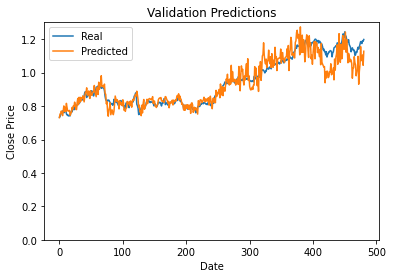


[370/100000]	Discriminator Loss: 0.9261	Generator Loss: 2.5207   	RMSE:0.1326
close | Real:0.4400 / Generated:0.3998
open | Real:0.4361 / Generated:0.4386
high | Real:0.4374 / Generated:0.4197
low | Real:0.4211 / Generated:0.4655
CUMLOGRET_1 | Real:0.7164 / Generated:0.6611
RSI_14 | Real:0.2052 / Generated:-0.0207
MACD_12_26_9 | Real:0.1668 / Generated:0.2371
SMA5 | Real:0.4488 / Generated:0.4662


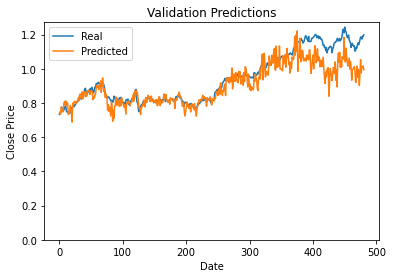


[375/100000]	Discriminator Loss: 1.0158	Generator Loss: 2.1718   	RMSE:0.1320
close | Real:0.0535 / Generated:0.0638
open | Real:0.0512 / Generated:0.0651
high | Real:0.0499 / Generated:0.0639
low | Real:0.0550 / Generated:0.0673
CUMLOGRET_1 | Real:0.1934 / Generated:0.1858
RSI_14 | Real:0.7642 / Generated:0.7437
MACD_12_26_9 | Real:0.6254 / Generated:0.6411
SMA5 | Real:0.0483 / Generated:0.0661


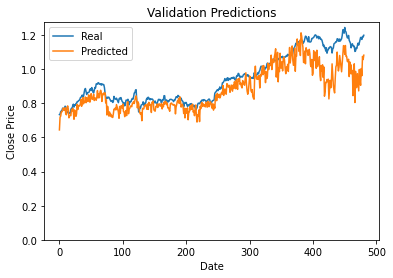


[380/100000]	Discriminator Loss: 1.5041	Generator Loss: 1.3700   	RMSE:0.1382
close | Real:0.9156 / Generated:0.9033
open | Real:0.9231 / Generated:0.8947
high | Real:0.9302 / Generated:0.9009
low | Real:0.9319 / Generated:0.8374
CUMLOGRET_1 | Real:0.9684 / Generated:1.0236
RSI_14 | Real:0.4626 / Generated:0.6931
MACD_12_26_9 | Real:0.5476 / Generated:0.5635
SMA5 | Real:0.9352 / Generated:0.9115


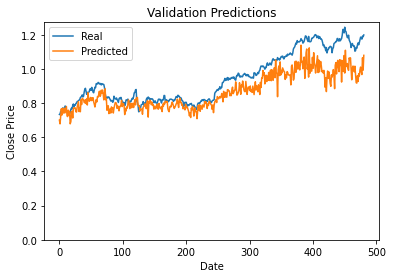


[385/100000]	Discriminator Loss: 1.5504	Generator Loss: 0.4534   	RMSE:0.1256
close | Real:0.2291 / Generated:0.2076
open | Real:0.2343 / Generated:0.2395
high | Real:0.2318 / Generated:0.2150
low | Real:0.2347 / Generated:0.2498
CUMLOGRET_1 | Real:0.5153 / Generated:0.5369
RSI_14 | Real:0.4652 / Generated:0.5121
MACD_12_26_9 | Real:0.6495 / Generated:0.6534
SMA5 | Real:0.2366 / Generated:0.2356


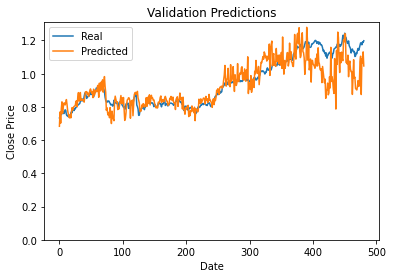


[390/100000]	Discriminator Loss: 0.9254	Generator Loss: 1.9363   	RMSE:0.1570
close | Real:0.5580 / Generated:0.5784
open | Real:0.5527 / Generated:0.5643
high | Real:0.5555 / Generated:0.5963
low | Real:0.5564 / Generated:0.5829
CUMLOGRET_1 | Real:0.7957 / Generated:0.8026
RSI_14 | Real:0.7318 / Generated:0.8809
MACD_12_26_9 | Real:0.7982 / Generated:0.8697
SMA5 | Real:0.5599 / Generated:0.5565


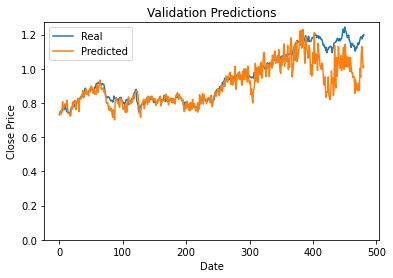


[395/100000]	Discriminator Loss: 0.9778	Generator Loss: 2.9700   	RMSE:0.1420
close | Real:0.4441 / Generated:0.4371
open | Real:0.4264 / Generated:0.4224
high | Real:0.4418 / Generated:0.4223
low | Real:0.4360 / Generated:0.3965
CUMLOGRET_1 | Real:0.7195 / Generated:0.7056
RSI_14 | Real:0.6440 / Generated:0.5224
MACD_12_26_9 | Real:0.7123 / Generated:0.6704
SMA5 | Real:0.4373 / Generated:0.3933


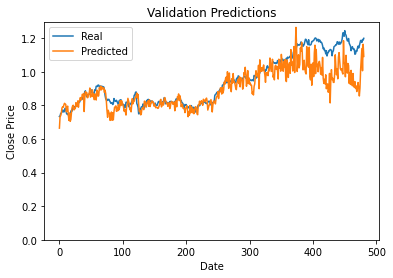


[400/100000]	Discriminator Loss: 0.9900	Generator Loss: 3.6657   	RMSE:0.1391
close | Real:0.1405 / Generated:0.1232
open | Real:0.1400 / Generated:0.1368
high | Real:0.1412 / Generated:0.1099
low | Real:0.1458 / Generated:0.1507
CUMLOGRET_1 | Real:0.3854 / Generated:0.3463
RSI_14 | Real:0.5998 / Generated:0.4989
MACD_12_26_9 | Real:0.6421 / Generated:0.6599
SMA5 | Real:0.1399 / Generated:0.1385


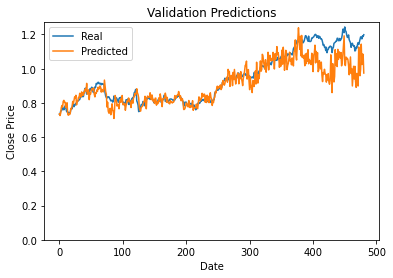


[405/100000]	Discriminator Loss: 1.0363	Generator Loss: 1.6625   	RMSE:0.1384
close | Real:0.2311 / Generated:0.2222
open | Real:0.2285 / Generated:0.2057
high | Real:0.2288 / Generated:0.2151
low | Real:0.2355 / Generated:0.2173
CUMLOGRET_1 | Real:0.5178 / Generated:0.5048
RSI_14 | Real:0.5979 / Generated:0.4892
MACD_12_26_9 | Real:0.6094 / Generated:0.5989
SMA5 | Real:0.2232 / Generated:0.2077


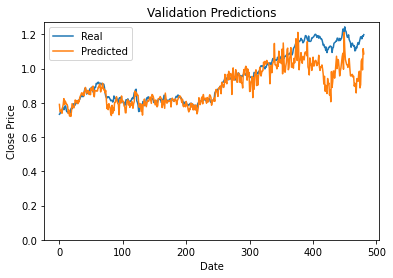


[410/100000]	Discriminator Loss: 1.2612	Generator Loss: 2.5127   	RMSE:0.1344
close | Real:0.0424 / Generated:0.0521
open | Real:0.0439 / Generated:0.0451
high | Real:0.0402 / Generated:0.0260
low | Real:0.0447 / Generated:0.0343
CUMLOGRET_1 | Real:0.1604 / Generated:0.1582
RSI_14 | Real:0.3763 / Generated:0.4052
MACD_12_26_9 | Real:0.5514 / Generated:0.5320
SMA5 | Real:0.0410 / Generated:0.0631


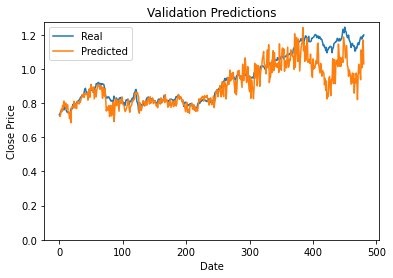


[415/100000]	Discriminator Loss: 1.0488	Generator Loss: 1.5947   	RMSE:0.1385
close | Real:0.5973 / Generated:0.5794
open | Real:0.6074 / Generated:0.6449
high | Real:0.6099 / Generated:0.5998
low | Real:0.6072 / Generated:0.5978
CUMLOGRET_1 | Real:0.8189 / Generated:0.7887
RSI_14 | Real:0.5364 / Generated:0.5771
MACD_12_26_9 | Real:0.6687 / Generated:0.6459
SMA5 | Real:0.6055 / Generated:0.5809


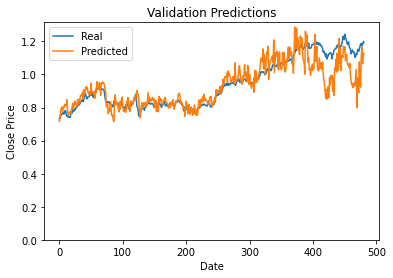


[420/100000]	Discriminator Loss: 1.2474	Generator Loss: 1.6033   	RMSE:0.1349
close | Real:0.6454 / Generated:0.6380
open | Real:0.6465 / Generated:0.6419
high | Real:0.6464 / Generated:0.6558
low | Real:0.6554 / Generated:0.6506
CUMLOGRET_1 | Real:0.8455 / Generated:0.8228
RSI_14 | Real:0.6601 / Generated:0.6531
MACD_12_26_9 | Real:0.7822 / Generated:0.7944
SMA5 | Real:0.6566 / Generated:0.6326


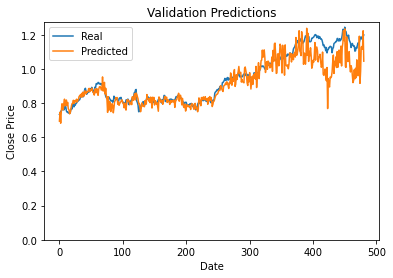


[425/100000]	Discriminator Loss: 1.1678	Generator Loss: 2.0368   	RMSE:0.1306
close | Real:0.2342 / Generated:0.2203
open | Real:0.2315 / Generated:0.2340
high | Real:0.2349 / Generated:0.2450
low | Real:0.2387 / Generated:0.2535
CUMLOGRET_1 | Real:0.5216 / Generated:0.5276
RSI_14 | Real:0.7847 / Generated:0.7778
MACD_12_26_9 | Real:0.7245 / Generated:0.7077
SMA5 | Real:0.2310 / Generated:0.2251


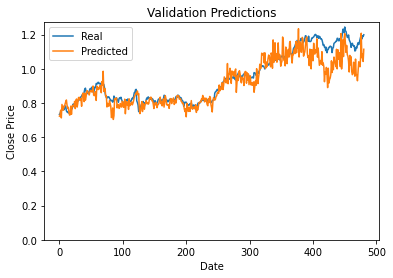


[430/100000]	Discriminator Loss: 0.9896	Generator Loss: 3.7462   	RMSE:0.1370
close | Real:0.0350 / Generated:0.0476
open | Real:0.0467 / Generated:0.0502
high | Real:0.0431 / Generated:0.0287
low | Real:0.0378 / Generated:0.0457
CUMLOGRET_1 | Real:0.1367 / Generated:0.1410
RSI_14 | Real:0.3199 / Generated:0.4469
MACD_12_26_9 | Real:0.5643 / Generated:0.5615
SMA5 | Real:0.0421 / Generated:0.0550


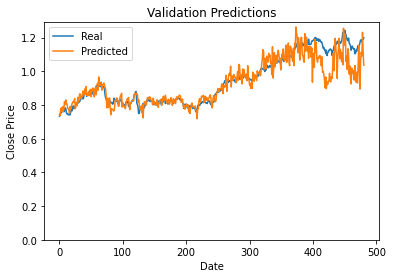


[435/100000]	Discriminator Loss: 1.1565	Generator Loss: 3.4943   	RMSE:0.1285
close | Real:0.2153 / Generated:0.2309
open | Real:0.2128 / Generated:0.1957
high | Real:0.2119 / Generated:0.2057
low | Real:0.2166 / Generated:0.2198
CUMLOGRET_1 | Real:0.4978 / Generated:0.5598
RSI_14 | Real:0.4691 / Generated:0.4334
MACD_12_26_9 | Real:0.5203 / Generated:0.4973
SMA5 | Real:0.2130 / Generated:0.2225


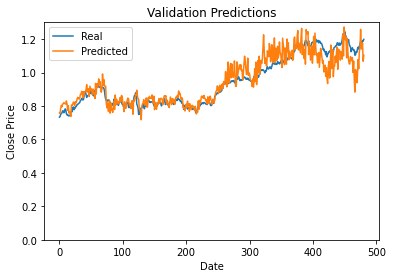


[440/100000]	Discriminator Loss: 0.7274	Generator Loss: 2.5205   	RMSE:0.1308
close | Real:0.0488 / Generated:0.0743
open | Real:0.0507 / Generated:0.0582
high | Real:0.0472 / Generated:0.0218
low | Real:0.0500 / Generated:0.0674
CUMLOGRET_1 | Real:0.1799 / Generated:0.1578
RSI_14 | Real:0.3659 / Generated:0.4372
MACD_12_26_9 | Real:0.5024 / Generated:0.5037
SMA5 | Real:0.0455 / Generated:0.0640


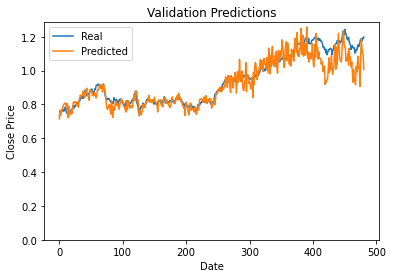


[445/100000]	Discriminator Loss: 1.0710	Generator Loss: 1.4073   	RMSE:0.1406
close | Real:0.1209 / Generated:0.1270
open | Real:0.1249 / Generated:0.1470
high | Real:0.1222 / Generated:0.1269
low | Real:0.1252 / Generated:0.1542
CUMLOGRET_1 | Real:0.3495 / Generated:0.3396
RSI_14 | Real:0.4678 / Generated:0.5031
MACD_12_26_9 | Real:0.6223 / Generated:0.6104
SMA5 | Real:0.1216 / Generated:0.1389


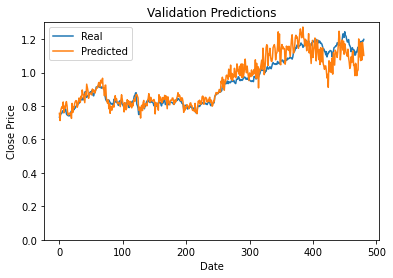


[450/100000]	Discriminator Loss: 0.9674	Generator Loss: 2.5570   	RMSE:0.1268
close | Real:0.4249 / Generated:0.4353
open | Real:0.4297 / Generated:0.4460
high | Real:0.4311 / Generated:0.4274
low | Real:0.4325 / Generated:0.4019
CUMLOGRET_1 | Real:0.7050 / Generated:0.7071
RSI_14 | Real:0.4753 / Generated:0.5537
MACD_12_26_9 | Real:0.5498 / Generated:0.5321
SMA5 | Real:0.4310 / Generated:0.4084


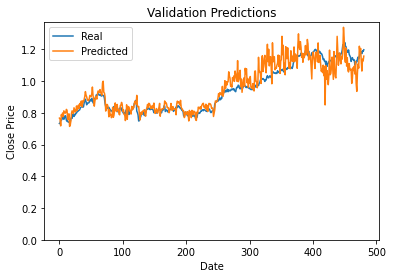


[455/100000]	Discriminator Loss: 0.8676	Generator Loss: 3.1964   	RMSE:0.1313
close | Real:0.0907 / Generated:0.0961
open | Real:0.0934 / Generated:0.0861
high | Real:0.0922 / Generated:0.1122
low | Real:0.0915 / Generated:0.1400
CUMLOGRET_1 | Real:0.2873 / Generated:0.2295
RSI_14 | Real:0.2883 / Generated:0.1284
MACD_12_26_9 | Real:0.5194 / Generated:0.4896
SMA5 | Real:0.0968 / Generated:0.0634


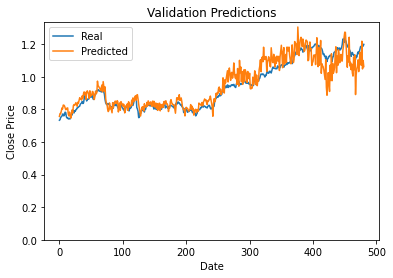


[460/100000]	Discriminator Loss: 1.1108	Generator Loss: 4.1195   	RMSE:0.1317
close | Real:0.0501 / Generated:0.0510
open | Real:0.0521 / Generated:0.0433
high | Real:0.0487 / Generated:0.0634
low | Real:0.0510 / Generated:0.0602
CUMLOGRET_1 | Real:0.1835 / Generated:0.1711
RSI_14 | Real:0.5918 / Generated:0.5608
MACD_12_26_9 | Real:0.6729 / Generated:0.6538
SMA5 | Real:0.0464 / Generated:0.0534


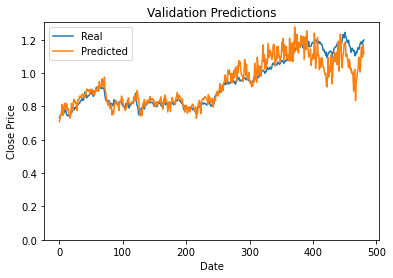


[465/100000]	Discriminator Loss: 1.0911	Generator Loss: 2.9551   	RMSE:0.1253
close | Real:0.8711 / Generated:0.8767
open | Real:0.8752 / Generated:0.8738
high | Real:0.8738 / Generated:0.9058
low | Real:0.8732 / Generated:0.8651
CUMLOGRET_1 | Real:0.9506 / Generated:0.9722
RSI_14 | Real:0.5916 / Generated:0.5599
MACD_12_26_9 | Real:0.7901 / Generated:0.7715
SMA5 | Real:0.8973 / Generated:0.8983


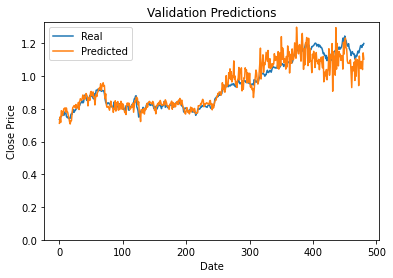


[470/100000]	Discriminator Loss: 0.9654	Generator Loss: 1.6628   	RMSE:0.1219
close | Real:0.0437 / Generated:0.0368
open | Real:0.0407 / Generated:0.0323
high | Real:0.0401 / Generated:0.0335
low | Real:0.0455 / Generated:0.0165
CUMLOGRET_1 | Real:0.1646 / Generated:0.1524
RSI_14 | Real:0.5162 / Generated:0.5012
MACD_12_26_9 | Real:0.5859 / Generated:0.5940
SMA5 | Real:0.0405 / Generated:0.0606


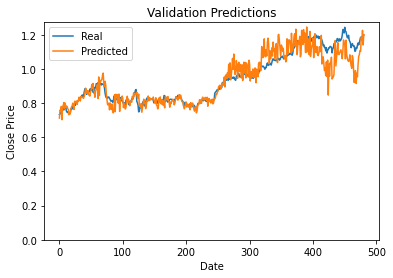


[475/100000]	Discriminator Loss: 0.8496	Generator Loss: 2.9862   	RMSE:0.1243
close | Real:0.1067 / Generated:0.0958
open | Real:0.1000 / Generated:0.1154
high | Real:0.1032 / Generated:0.0748
low | Real:0.1055 / Generated:0.1426
CUMLOGRET_1 | Real:0.3216 / Generated:0.2831
RSI_14 | Real:0.7371 / Generated:0.6870
MACD_12_26_9 | Real:0.6699 / Generated:0.6551
SMA5 | Real:0.0935 / Generated:0.0772


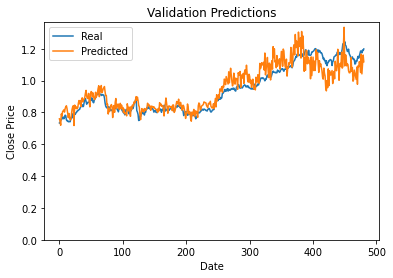


[480/100000]	Discriminator Loss: 1.0562	Generator Loss: 3.4417   	RMSE:0.1218
close | Real:0.3542 / Generated:0.3497
open | Real:0.3492 / Generated:0.3623
high | Real:0.3509 / Generated:0.3528
low | Real:0.3557 / Generated:0.3532
CUMLOGRET_1 | Real:0.6466 / Generated:0.6393
RSI_14 | Real:0.5668 / Generated:0.5068
MACD_12_26_9 | Real:0.6371 / Generated:0.6410
SMA5 | Real:0.3562 / Generated:0.3372


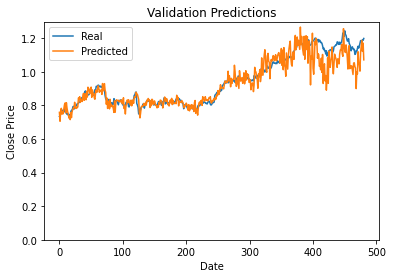


[485/100000]	Discriminator Loss: 1.1833	Generator Loss: 0.9217   	RMSE:0.1213
close | Real:0.0430 / Generated:0.0447
open | Real:0.0418 / Generated:0.0449
high | Real:0.0393 / Generated:0.0461
low | Real:0.0463 / Generated:0.0233
CUMLOGRET_1 | Real:0.1622 / Generated:0.1520
RSI_14 | Real:0.5375 / Generated:0.5094
MACD_12_26_9 | Real:0.5843 / Generated:0.5706
SMA5 | Real:0.0395 / Generated:0.0560


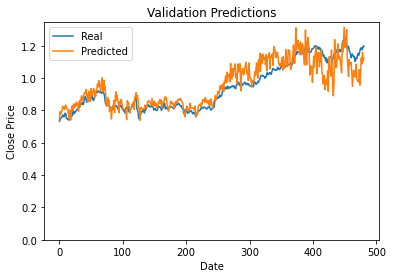


[490/100000]	Discriminator Loss: 1.2712	Generator Loss: 0.8165   	RMSE:0.1198
close | Real:0.4752 / Generated:0.4684
open | Real:0.4638 / Generated:0.5220
high | Real:0.4721 / Generated:0.4770
low | Real:0.4717 / Generated:0.4763
CUMLOGRET_1 | Real:0.7418 / Generated:0.7231
RSI_14 | Real:0.7524 / Generated:0.6954
MACD_12_26_9 | Real:0.7816 / Generated:0.7698
SMA5 | Real:0.4679 / Generated:0.4441


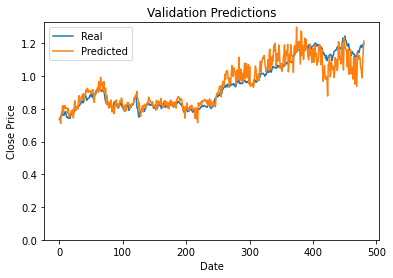


[495/100000]	Discriminator Loss: 1.2393	Generator Loss: 1.5091   	RMSE:0.1218
close | Real:0.9171 / Generated:0.9327
open | Real:0.9124 / Generated:0.8962
high | Real:0.9197 / Generated:0.9144
low | Real:0.9233 / Generated:0.8877
CUMLOGRET_1 | Real:0.9690 / Generated:1.0429
RSI_14 | Real:0.6585 / Generated:0.4718
MACD_12_26_9 | Real:0.6942 / Generated:0.6784
SMA5 | Real:0.9231 / Generated:0.8931


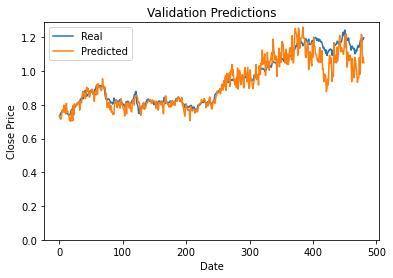


[500/100000]	Discriminator Loss: 0.8927	Generator Loss: 3.7064   	RMSE:0.1172
close | Real:0.0331 / Generated:0.0492
open | Real:0.0354 / Generated:0.0348
high | Real:0.0336 / Generated:-0.0145
low | Real:0.0360 / Generated:0.0391
CUMLOGRET_1 | Real:0.1305 / Generated:0.1393
RSI_14 | Real:0.4915 / Generated:0.5338
MACD_12_26_9 | Real:0.5283 / Generated:0.5697
SMA5 | Real:0.0259 / Generated:0.0079


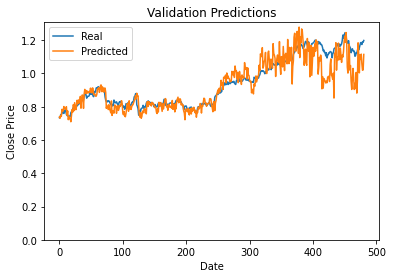


[505/100000]	Discriminator Loss: 1.0717	Generator Loss: 1.9735   	RMSE:0.1237
close | Real:0.8065 / Generated:0.7715
open | Real:0.8067 / Generated:0.7860
high | Real:0.8097 / Generated:0.8091
low | Real:0.8210 / Generated:0.7889
CUMLOGRET_1 | Real:0.9233 / Generated:0.9050
RSI_14 | Real:0.5608 / Generated:0.4647
MACD_12_26_9 | Real:0.5678 / Generated:0.5498
SMA5 | Real:0.8063 / Generated:0.8398


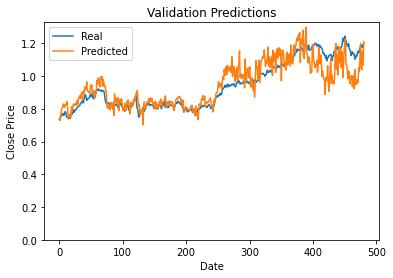


[510/100000]	Discriminator Loss: 1.1538	Generator Loss: 3.9142   	RMSE:0.1227
close | Real:0.5649 / Generated:0.5674
open | Real:0.5889 / Generated:0.6373
high | Real:0.5884 / Generated:0.6244
low | Real:0.5748 / Generated:0.5838
CUMLOGRET_1 | Real:0.7998 / Generated:0.8220
RSI_14 | Real:0.4230 / Generated:0.6240
MACD_12_26_9 | Real:0.5637 / Generated:0.5897
SMA5 | Real:0.5871 / Generated:0.6097


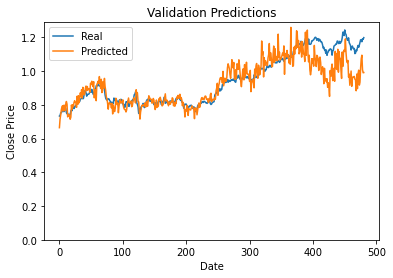


[515/100000]	Discriminator Loss: 0.8465	Generator Loss: 2.7802   	RMSE:0.1278
close | Real:0.9302 / Generated:0.9932
open | Real:0.9536 / Generated:0.8798
high | Real:0.9501 / Generated:0.9435
low | Real:0.9466 / Generated:0.9164
CUMLOGRET_1 | Real:0.9740 / Generated:1.2649
RSI_14 | Real:0.3926 / Generated:0.4598
MACD_12_26_9 | Real:0.7575 / Generated:0.8177
SMA5 | Real:0.9800 / Generated:0.9149


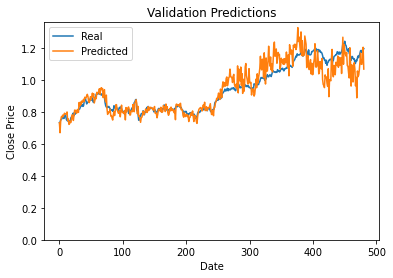


[520/100000]	Discriminator Loss: 0.8868	Generator Loss: 3.0888   	RMSE:0.1274
close | Real:0.0647 / Generated:0.0659
open | Real:0.0587 / Generated:0.0120
high | Real:0.0621 / Generated:0.0740
low | Real:0.0625 / Generated:0.0720
CUMLOGRET_1 | Real:0.2242 / Generated:0.2359
RSI_14 | Real:0.7812 / Generated:0.8763
MACD_12_26_9 | Real:0.7616 / Generated:0.7286
SMA5 | Real:0.0592 / Generated:0.0707


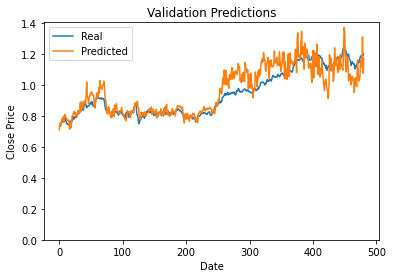


[525/100000]	Discriminator Loss: 0.8464	Generator Loss: 2.9460   	RMSE:0.1254
close | Real:0.6995 / Generated:0.7013
open | Real:0.7132 / Generated:0.6742
high | Real:0.7156 / Generated:0.6811
low | Real:0.7116 / Generated:0.7112
CUMLOGRET_1 | Real:0.8734 / Generated:0.8523
RSI_14 | Real:0.3947 / Generated:0.3822
MACD_12_26_9 | Real:0.3137 / Generated:0.2984
SMA5 | Real:0.7114 / Generated:0.7441


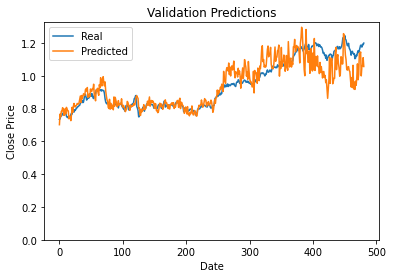


[530/100000]	Discriminator Loss: 0.9576	Generator Loss: 2.0245   	RMSE:0.1273
close | Real:0.6788 / Generated:0.6528
open | Real:0.6801 / Generated:0.7336
high | Real:0.6825 / Generated:0.7184
low | Real:0.6879 / Generated:0.6902
CUMLOGRET_1 | Real:0.8629 / Generated:0.8551
RSI_14 | Real:0.8852 / Generated:0.8498
MACD_12_26_9 | Real:0.8309 / Generated:0.8223
SMA5 | Real:0.6813 / Generated:0.6840


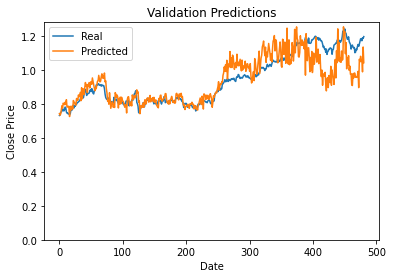


[535/100000]	Discriminator Loss: 0.7210	Generator Loss: 3.5221   	RMSE:0.1290
close | Real:0.0260 / Generated:0.0178
open | Real:0.0246 / Generated:0.0076
high | Real:0.0223 / Generated:0.0343
low | Real:0.0278 / Generated:-0.0046
CUMLOGRET_1 | Real:0.1059 / Generated:0.1006
RSI_14 | Real:0.3494 / Generated:0.3428
MACD_12_26_9 | Real:0.5594 / Generated:0.5369
SMA5 | Real:0.0225 / Generated:0.0581


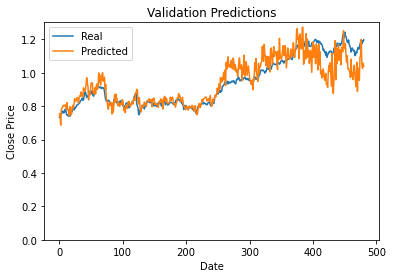


[540/100000]	Discriminator Loss: 1.1329	Generator Loss: 1.9056   	RMSE:0.1246
close | Real:0.0297 / Generated:0.0227
open | Real:0.0226 / Generated:-0.0044
high | Real:0.0260 / Generated:0.0080
low | Real:0.0261 / Generated:0.0079
CUMLOGRET_1 | Real:0.1189 / Generated:0.0425
RSI_14 | Real:0.4166 / Generated:0.1577
MACD_12_26_9 | Real:0.4926 / Generated:0.4633
SMA5 | Real:0.0194 / Generated:0.0243


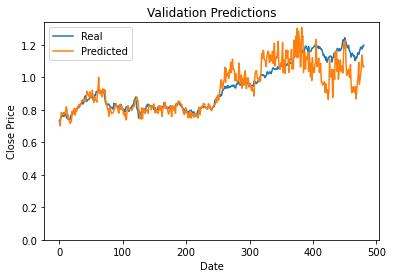


[545/100000]	Discriminator Loss: 0.7030	Generator Loss: 3.0911   	RMSE:0.1297
close | Real:0.7059 / Generated:0.7111
open | Real:0.7166 / Generated:0.7122
high | Real:0.7130 / Generated:0.7555
low | Real:0.7159 / Generated:0.7349
CUMLOGRET_1 | Real:0.8765 / Generated:0.8368
RSI_14 | Real:0.5349 / Generated:0.6614
MACD_12_26_9 | Real:0.6652 / Generated:0.6865
SMA5 | Real:0.7186 / Generated:0.7328


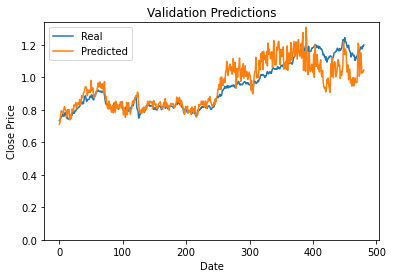


[550/100000]	Discriminator Loss: 0.8390	Generator Loss: 3.7251   	RMSE:0.1339
close | Real:0.6553 / Generated:0.6753
open | Real:0.6735 / Generated:0.6392
high | Real:0.6764 / Generated:0.6778
low | Real:0.6606 / Generated:0.6643
CUMLOGRET_1 | Real:0.8507 / Generated:0.8166
RSI_14 | Real:0.3021 / Generated:0.2497
MACD_12_26_9 | Real:0.4437 / Generated:0.4390
SMA5 | Real:0.6863 / Generated:0.6623


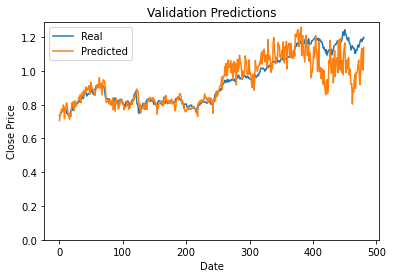


[555/100000]	Discriminator Loss: 1.1562	Generator Loss: 3.6133   	RMSE:0.1332
close | Real:0.3968 / Generated:0.4003
open | Real:0.4101 / Generated:0.4446
high | Real:0.4088 / Generated:0.4190
low | Real:0.4064 / Generated:0.4212
CUMLOGRET_1 | Real:0.6829 / Generated:0.7127
RSI_14 | Real:0.3771 / Generated:0.5163
MACD_12_26_9 | Real:0.5766 / Generated:0.5917
SMA5 | Real:0.4119 / Generated:0.3930


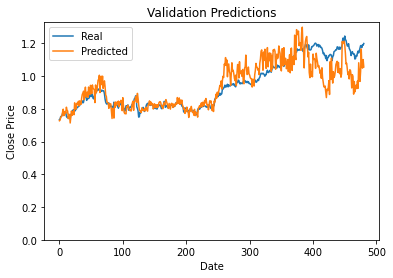


[560/100000]	Discriminator Loss: 0.7039	Generator Loss: 4.0432   	RMSE:0.1290
close | Real:0.3586 / Generated:0.3558
open | Real:0.3572 / Generated:0.3515
high | Real:0.3584 / Generated:0.3445
low | Real:0.3642 / Generated:0.3331
CUMLOGRET_1 | Real:0.6505 / Generated:0.6597
RSI_14 | Real:0.2944 / Generated:0.3825
MACD_12_26_9 | Real:0.4482 / Generated:0.4030
SMA5 | Real:0.3664 / Generated:0.3550


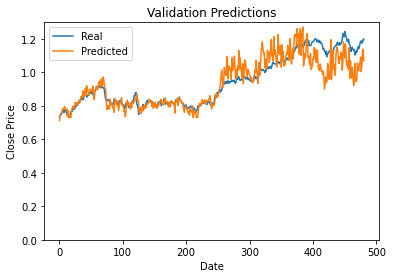


[565/100000]	Discriminator Loss: 1.0891	Generator Loss: 2.6713   	RMSE:0.1317
close | Real:0.0261 / Generated:0.0205
open | Real:0.0289 / Generated:0.0436
high | Real:0.0252 / Generated:0.0367
low | Real:0.0254 / Generated:0.0295
CUMLOGRET_1 | Real:0.1064 / Generated:0.1252
RSI_14 | Real:0.3124 / Generated:0.3730
MACD_12_26_9 | Real:0.5340 / Generated:0.5547
SMA5 | Real:0.0278 / Generated:0.0394


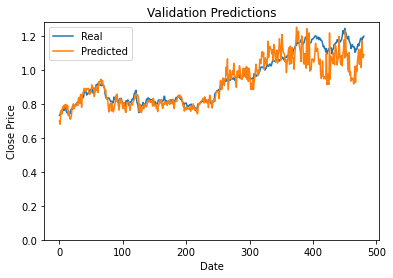


[570/100000]	Discriminator Loss: 1.2407	Generator Loss: 3.3468   	RMSE:0.1326
close | Real:0.4619 / Generated:0.4607
open | Real:0.4693 / Generated:0.4588
high | Real:0.4725 / Generated:0.4439
low | Real:0.4706 / Generated:0.4368
CUMLOGRET_1 | Real:0.7324 / Generated:0.7268
RSI_14 | Real:0.6354 / Generated:0.6250
MACD_12_26_9 | Real:0.7715 / Generated:0.7473
SMA5 | Real:0.4717 / Generated:0.4454


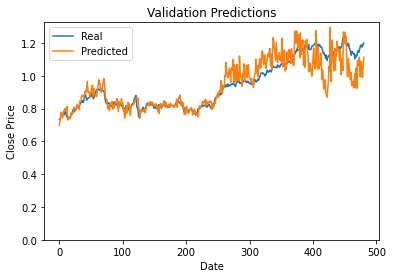


[575/100000]	Discriminator Loss: 0.8943	Generator Loss: 4.1539   	RMSE:0.1362
close | Real:0.3599 / Generated:0.3596
open | Real:0.3541 / Generated:0.3744
high | Real:0.3580 / Generated:0.3606
low | Real:0.3567 / Generated:0.3664
CUMLOGRET_1 | Real:0.6517 / Generated:0.6503
RSI_14 | Real:0.5558 / Generated:0.5563
MACD_12_26_9 | Real:0.6326 / Generated:0.6388
SMA5 | Real:0.3644 / Generated:0.3432


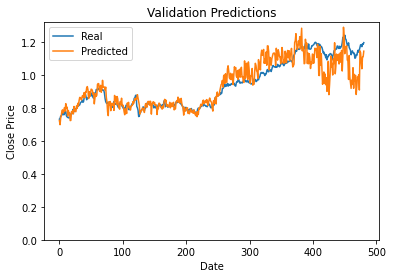


[580/100000]	Discriminator Loss: 0.8380	Generator Loss: 2.6784   	RMSE:0.1209
close | Real:0.8843 / Generated:0.8532
open | Real:0.8688 / Generated:0.8451
high | Real:0.8816 / Generated:0.8729
low | Real:0.8839 / Generated:0.8720
CUMLOGRET_1 | Real:0.9560 / Generated:0.9525
RSI_14 | Real:0.5193 / Generated:0.3687
MACD_12_26_9 | Real:0.6357 / Generated:0.6188
SMA5 | Real:0.8833 / Generated:0.8407


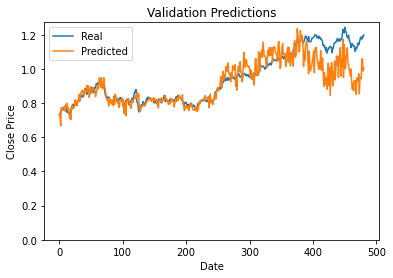


[585/100000]	Discriminator Loss: 0.8027	Generator Loss: 2.1544   	RMSE:0.1327
close | Real:0.2098 / Generated:0.2168
open | Real:0.2058 / Generated:0.1741
high | Real:0.2068 / Generated:0.1808
low | Real:0.2124 / Generated:0.1961
CUMLOGRET_1 | Real:0.4905 / Generated:0.5202
RSI_14 | Real:0.5503 / Generated:0.4986
MACD_12_26_9 | Real:0.5939 / Generated:0.5962
SMA5 | Real:0.2091 / Generated:0.2209


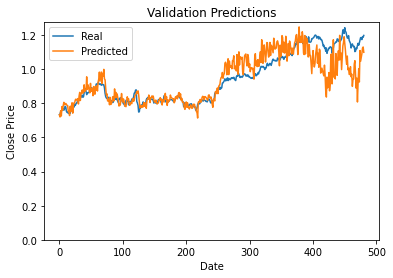


[590/100000]	Discriminator Loss: 0.8182	Generator Loss: 3.2381   	RMSE:0.1325
close | Real:0.1350 / Generated:0.1247
open | Real:0.1344 / Generated:0.1560
high | Real:0.1347 / Generated:0.1242
low | Real:0.1403 / Generated:0.1457
CUMLOGRET_1 | Real:0.3756 / Generated:0.3577
RSI_14 | Real:0.5444 / Generated:0.5354
MACD_12_26_9 | Real:0.6155 / Generated:0.6288
SMA5 | Real:0.1318 / Generated:0.1217


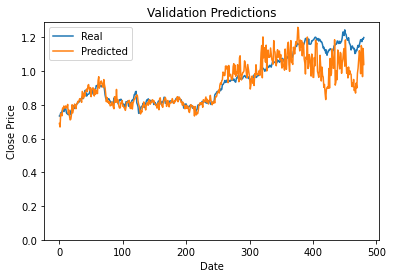


[595/100000]	Discriminator Loss: 0.8333	Generator Loss: 4.0272   	RMSE:0.1290
close | Real:0.7844 / Generated:0.7438
open | Real:0.7883 / Generated:0.7262
high | Real:0.7878 / Generated:0.7234
low | Real:0.7899 / Generated:0.8028
CUMLOGRET_1 | Real:0.9135 / Generated:0.9007
RSI_14 | Real:0.1917 / Generated:0.1460
MACD_12_26_9 | Real:0.3824 / Generated:0.3166
SMA5 | Real:0.8089 / Generated:0.8099


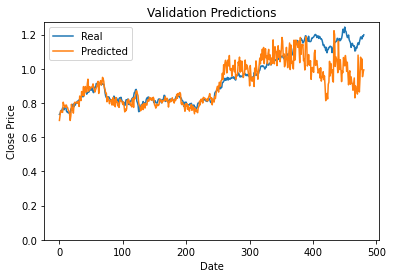


[600/100000]	Discriminator Loss: 0.9555	Generator Loss: 2.8979   	RMSE:0.1404
close | Real:0.0483 / Generated:0.0469
open | Real:0.0505 / Generated:0.0570
high | Real:0.0478 / Generated:0.0697
low | Real:0.0525 / Generated:0.0998
CUMLOGRET_1 | Real:0.1782 / Generated:0.2195
RSI_14 | Real:0.6690 / Generated:0.8387
MACD_12_26_9 | Real:0.6048 / Generated:0.6299
SMA5 | Real:0.0422 / Generated:0.0487


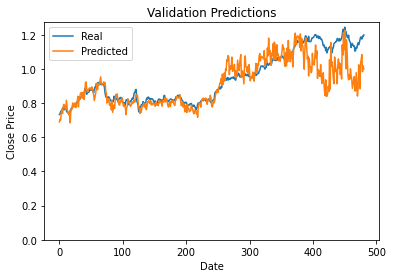


[605/100000]	Discriminator Loss: 0.9715	Generator Loss: 3.2637   	RMSE:0.1415
close | Real:0.3517 / Generated:0.3252
open | Real:0.3506 / Generated:0.3682
high | Real:0.3485 / Generated:0.3789
low | Real:0.3567 / Generated:0.3751
CUMLOGRET_1 | Real:0.6444 / Generated:0.6740
RSI_14 | Real:0.5822 / Generated:0.5500
MACD_12_26_9 | Real:0.6387 / Generated:0.6368
SMA5 | Real:0.3510 / Generated:0.3608


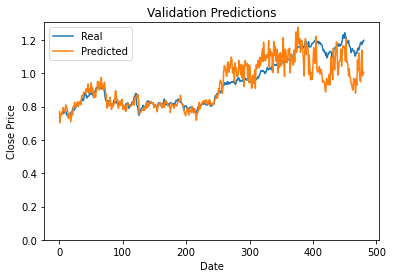


[610/100000]	Discriminator Loss: 0.8491	Generator Loss: 2.4859   	RMSE:0.1370
close | Real:0.0622 / Generated:0.0453
open | Real:0.0600 / Generated:0.0830
high | Real:0.0585 / Generated:0.0913
low | Real:0.0638 / Generated:0.0789
CUMLOGRET_1 | Real:0.2174 / Generated:0.2143
RSI_14 | Real:0.7979 / Generated:0.7623
MACD_12_26_9 | Real:0.6245 / Generated:0.6473
SMA5 | Real:0.0537 / Generated:0.0304


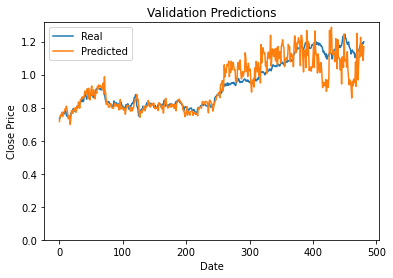


[615/100000]	Discriminator Loss: 1.1864	Generator Loss: 2.4318   	RMSE:0.1337
close | Real:0.3237 / Generated:0.3935
open | Real:0.3288 / Generated:0.2759
high | Real:0.3278 / Generated:0.2819
low | Real:0.3303 / Generated:0.3400
CUMLOGRET_1 | Real:0.6184 / Generated:0.6428
RSI_14 | Real:0.7487 / Generated:0.8344
MACD_12_26_9 | Real:0.8441 / Generated:0.8348
SMA5 | Real:0.3280 / Generated:0.3231


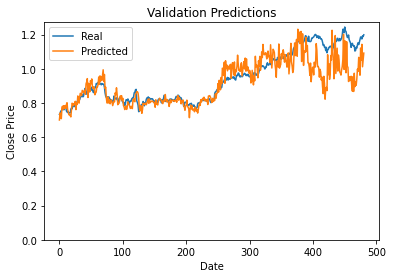


[620/100000]	Discriminator Loss: 0.9431	Generator Loss: 3.3403   	RMSE:0.1306
close | Real:0.5506 / Generated:0.5126
open | Real:0.5188 / Generated:0.5382
high | Real:0.5475 / Generated:0.5421
low | Real:0.5283 / Generated:0.5251
CUMLOGRET_1 | Real:0.7911 / Generated:0.7759
RSI_14 | Real:0.4956 / Generated:0.4570
MACD_12_26_9 | Real:0.3877 / Generated:0.3924
SMA5 | Real:0.5278 / Generated:0.5394


KeyboardInterrupt: 

In [20]:
evaluation_metrics = {"gen_loss":[], "disc_loss":[], "rmse":[]}
                      
print("Training is started")
for epoch in range(num_epochs):
    for i, sequence_batch in enumerate(train_dataloader):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Training with real batch
            discriminator.zero_grad()
            # Format batch
            real_sequence = sequence_batch.to(device)
            batch_size = real_sequence.size(0)
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            discriminator_output_real = discriminator(real_sequence).view(-1)
            # Calculate loss on all-real batch
            discriminator_error_real = criterion(discriminator_output_real, real_labels)
            # Calculate gradients for D in backward pass
            discriminator_error_real.backward()

            ## Training with fake batch
            # Assign first t values
            generator_input_sequence = sequence_batch[:,:-1].to(device)
            #  Generate (t+1)th value from first t values
            generated_values = generator(generator_input_sequence)
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
            # Concat first t real values and generated (t+1)th values
            generator_result_concat = torch.cat((generator_input_sequence, generated_values.detach()), 1)
            # Classify all fake batch with D
            discriminator_output_fake = discriminator(generator_result_concat).view(-1)
            # Calculate D's loss on the all-fake batch
            discriminator_error_fake = criterion(discriminator_output_fake, fake_labels)
            # Calculate the gradients for this batch
            discriminator_error_fake.backward()
            # Add the gradients from the all-real and all-fake batches
            discriminator_error = discriminator_error_real + discriminator_error_fake
            # Update D
            optimizer_discriminator.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            generator.zero_grad()
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            # Since we just updated D, perform another forward pass of all-fake batch through D
            generator_result_concat_grad = torch.cat((generator_input_sequence, generated_values), 1)
            discriminator_output_fake = discriminator(generator_result_concat_grad).view(-1)
            # Calculate G's loss based on this output
            generator_error = criterion(discriminator_output_fake, real_labels)
            # Calculate gradients for G
            generator_error.backward()
            # Update G
            optimizer_generator.step()
    if (epoch+1) % 5 == 0 or epoch+1 == 1:
        rmse = model_rmse(generator, validation_dataloader, plot_graph=True)
        evaluation_metrics["rmse"].append(rmse)
        evaluation_metrics["gen_loss"].append(generator_error.item())
        evaluation_metrics["disc_loss"].append(discriminator_error.item())
        print('\n[{}/{}]\tDiscriminator Loss: {:.4f}\tGenerator Loss: {:.4f}   \tRMSE:{:.4f}'
                  .format(epoch+1, num_epochs, discriminator_error.item(), generator_error.item(), rmse))
        for col_name, real, generated in zip(columns_used_in_training, sequence_batch[0][-1], generated_values[0][0]):
            print(f"{col_name} | Real:{real:.4f} / Generated:{generated:.4f}")
        save_path = os.path.join("./models/","model_epoch_{}.pt".format(epoch+1))
        torch.save({
            'epoch': epoch+1,
            'generator_model_state_dict': generator.state_dict(),
            'discriminator_model_state_dict': discriminator.state_dict(),
            'optimizer_generator_state_dict': optimizer_generator.state_dict(),
            'optimizer_discriminator_state_dict': optimizer_discriminator.state_dict(),
            'discriminator_loss': discriminator_error,
            'generator_loss': generator_error,
            }, save_path)